In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
pi_real.shape

(150, 2016)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

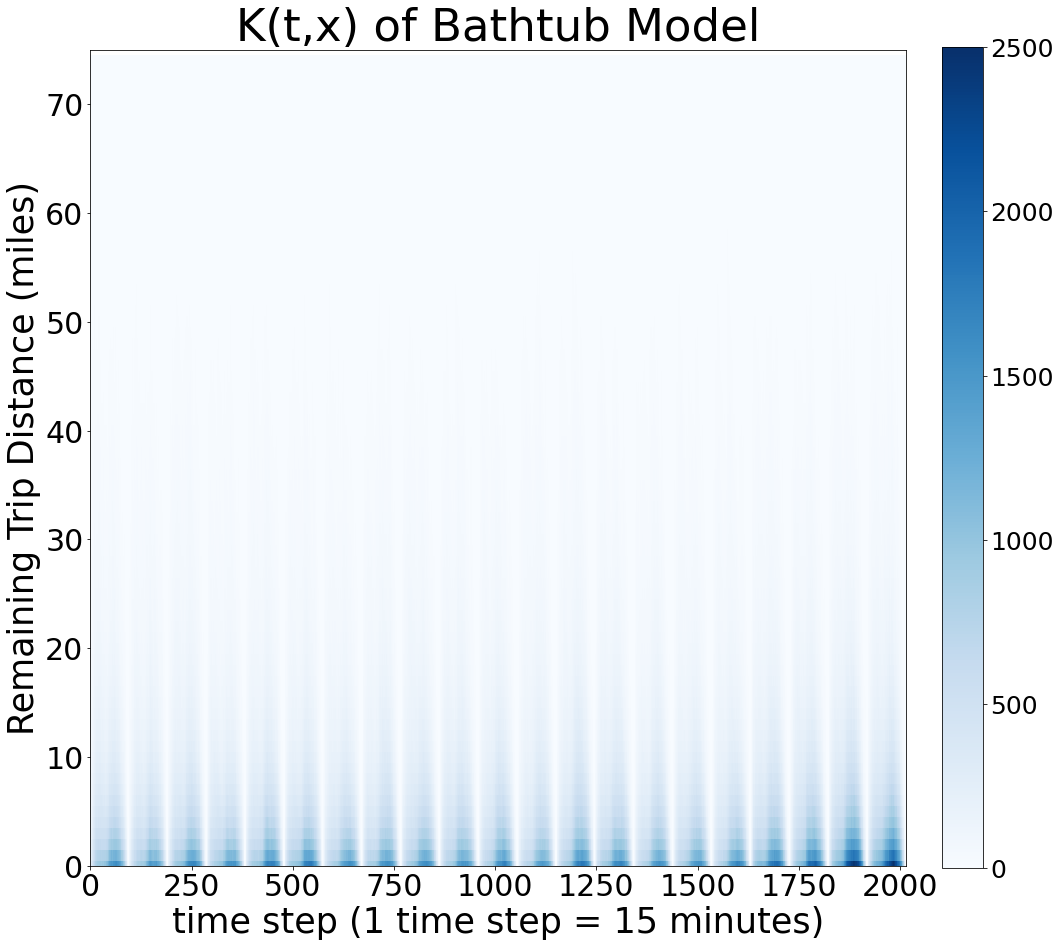

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
Size_diststep = 5 # unit: miles
size_input = int(N_diststep/Size_diststep)*N_timestep # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  30240
N_u =  6048
N_f =  12096


In [7]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [8]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [9]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1234)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [10]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [11]:
X_u_train.shape

(6048, 2)

In [12]:
X_u_test.shape

(24192, 2)

In [13]:
X_u_train

array([[0.        , 0.02630273],
       [0.54054054, 0.8382134 ],
       [0.94594595, 0.23722084],
       ...,
       [0.47297297, 0.98957816],
       [0.06756757, 0.87394541],
       [0.54054054, 0.92704715]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [14]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    # Loss of data discrepancy
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    # Loss of physics
    def loss_PDE(self, x_to_train_f, f_t, pi_tx, v_t):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
        ft = tf.Variable(f_t,dtype = 'float64', trainable = False)
        pitx = tf.Variable(pi_tx,dtype = 'float64', trainable = False)
        vt = tf.Variable(v_t,dtype = 'float64', trainable = False)
    
        x_f = g[:,0:1]
        t_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            z = self.evaluate(g)
            u_x = tape.gradient(z,x_f)

        u_t = tape.gradient(z,t_f)
        
        del tape

        f = u_t - vt*(u_x) - tf.multiply(ft, pitx)
        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    # total loss
    def loss(self,x,y,g,h,i,k,alpha):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g,h,i,k)

        loss = alpha*loss_u + (1-alpha)*loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        tf.print(loss_value, loss_u, loss_f, error_vec)
        

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [15]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,10,10,10,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.012035661546054701 0.021706312946460589 0.0023650101456488136 1.1191947096234347
0.0067861595904903623 0.012926358215550361 0.00064596096543036326 0.8726139298560016
0.0064196752359458164 0.012164793370307214 0.000674557101584419 0.8474142770268817
0.0061715202916202173 0.011589067000595815 0.00075397358264461985 0.8273851739015508
0.0054905288522994495 0.010177354955837237 0.00080370274876166215 0.7747777503042901
0.0052079941919764318 0.0098609201060430723 0.00055506827790979189 0.7608440170539176
0.0051833114803902566 0.0098582621788570052 0.00050836078192350773 0.7601750258229495
0.0051779547721818968 0.0098619326374169113 0.00049397690694688307 0.760236608412559
0.0051638347642427819 0.00986553446326122 0.00046213506522434466 0.7603039521025586
0.0051350058130376292 0.0098601826605528159 0.00040982896552244254 0.7601093905625637
0.0050799925780696531 0.0098225010725171719 0.00033748408362213497 0.7588953768343217
0.0050115394086394562 0.009727339214663365 0.0002957396026155479 0

0.0032443205254789505 0.0055787572713038623 0.000909883779654039 0.5780782999951015
0.0032433553956150146 0.0055777220006547838 0.000908988790575245 0.5779714728620594
0.00324259115275142 0.0055994178825060446 0.0008857644229967954 0.5789902198732034
0.0032422510916960234 0.0055939003883127454 0.00089060179507930164 0.5786969813916484
0.003241744039778097 0.0056002782138528618 0.00088320986570333219 0.579058627575073
0.0032413816209267785 0.0055921481170877968 0.00089061512476576031 0.5786374855211481
0.0032411561290600624 0.005598870097692713 0.000883442160427412 0.578975112760982
0.0032409897919819818 0.00559826886157069 0.00088371072239327357 0.5789247641695348
0.003240775921865423 0.0056044889619887546 0.00087706288174209119 0.5792450785426652
0.003240433918603753 0.0056059953246989681 0.00087487251250853741 0.5793016469143379
0.0032397752665727208 0.0056085132318539057 0.00087103730129153541 0.579414522306308
0.003237764601731169 0.0056103245134411731 0.00086520469002116516 0.5794

0.0032011636007956198 0.0055110488361641667 0.00089127836542707273 0.5743056859777778
0.0032005796886796006 0.0054995171038622068 0.00090164227349699482 0.5736955114323924
0.0032002354474952328 0.0054882488829438763 0.00091222201204658885 0.5731390345919823
0.0031999821972723184 0.0054896955581936529 0.0009102688363509839 0.5732160227290201
0.0031997894089919078 0.0054938251658113594 0.00090575365217245582 0.5734278414718859
0.0031997312160636088 0.0054916974165763353 0.00090776501555088224 0.5732964357155572
0.0031996504621180227 0.0054912638882227026 0.00090803703601334313 0.5732962102264563
0.0031996085522434116 0.0054919091617243749 0.00090730794276244807 0.5733136453691094
0.0031995568378935793 0.0054962283753487058 0.00090288530043845263 0.573524388826494
0.0031995177087762216 0.0054969997511980341 0.00090203566635440886 0.5735590077076089
0.0031994412420215121 0.0054987672042681448 0.00090011527977487942 0.5736437922347715
0.0031992936954162981 0.0054994149935143179 0.0008991723

0.0031724112286031342 0.0054322362105209973 0.0009125862466852709 0.5696929286633103
0.0031724012082570592 0.0054315826974888114 0.00091321971902530669 0.5696602349735017
0.0031723796778221243 0.0054297444206928211 0.00091501493495142717 0.5695648345326976
0.003172356807371499 0.0054299152993580665 0.00091479831538493158 0.569573703038564
0.0031723233566594965 0.0054266937954617987 0.00091795291785719475 0.5694029610730531
0.0031722800541225948 0.0054290423656582279 0.000915517742586962 0.5695242190722465
0.003172224452679619 0.0054304239800039272 0.000914024925355311 0.5695865621169098
0.0031721731451079507 0.0054375642633996144 0.0009067820268162869 0.5699464034333868
0.0031721165623596771 0.00543599783793658 0.000908235286782774 0.5698595684186502
0.0031720554404833217 0.0054334986915029358 0.00091061218946370751 0.5697311237547894
0.0031720199057391411 0.0054305472665471064 0.0009134925449311755 0.5695557236375774
0.0031719812351963615 0.00543223541455166 0.00091172705584106244 0.5

0.0031676305998232512 0.0054385187121766482 0.00089674248746985383 0.5699457369715943
0.0031672827278874296 0.0054411658228276372 0.000893399632947222 0.5700686433648019
0.0031671080228701377 0.0054292672411695936 0.00090494880457068171 0.5695075639431918
0.0031668803292980276 0.005432640536087969 0.00090112012250808575 0.5696715413789584
0.0031667364387724158 0.0054342889137912838 0.000899183963753548 0.5697187300026916
0.0031666740900090583 0.0054385701719999024 0.00089477800801821428 0.5699411660811192
0.0031666248921322616 0.0054445835363011608 0.0008886662479633625 0.5702292978051088
0.0031663956028178692 0.00543837156564882 0.00089441963998691787 0.5699223707092879
0.0031663059124484986 0.0054322479378174394 0.00090036388707955776 0.5696240239324883
0.0031661277035481598 0.0054378221461336956 0.000894433260962624 0.5699093525579617
0.0031654866610004739 0.00544652955904314 0.00088444376295780723 0.5703282143292799
0.0031651107905878119 0.0054426138267718088 0.00088760775440381524

0.0031287044233225076 0.0053764055850401542 0.00088100326160486147 0.566705412301095
0.0031286636464396768 0.0053741111223540644 0.00088321617052528924 0.5665840700829784
0.0031286303323787229 0.0053733451607776532 0.00088391550397979267 0.5665406419771202
0.0031285754026511305 0.00537180557812703 0.00088534522717523094 0.5664596036457573
0.0031284133581345121 0.0053706400580708609 0.00088618665819816325 0.5663887525352281
0.0031280520561345051 0.0053690500825493738 0.00088705402971963688 0.5662846475487715
0.0031273594890933679 0.005369659362309741 0.00088505961587699469 0.5662957140503206
0.0031261838750319126 0.0053771746180359915 0.000875193132027834 0.5666808229871352
0.0031248002336943339 0.005373422776293893 0.00087617769109477506 0.5663923878402247
0.003123272099021729 0.0053819091098493942 0.00086463508819406359 0.566836176298806
0.0031198019396494053 0.0053741409544728353 0.000865462924825975 0.5664604838841554
0.0031184604860400372 0.0053752455795522689 0.0008616753925278058

0.0030753670369502327 0.0053033631329207154 0.00084737094097975013 0.5621046810922957
0.0030749699078623759 0.0053018394354612652 0.00084810038026348624 0.5620041633462013
0.0030742072117425447 0.0053009156047965451 0.00084749881868854461 0.5619965245412933
0.0030738736916137237 0.0053009449089055187 0.00084680247432192875 0.5619779799715429
0.003073339262743936 0.0053125429353338182 0.00083413559015405384 0.5626444274190594
0.0030730024319235143 0.0053172398532883849 0.00082876501055864367 0.5628555915287325
0.0030726124292322862 0.0053135094830565437 0.00083171537540802868 0.5626680603372988
0.003072110505935987 0.0053023176977741388 0.00084190331409783484 0.5620814358803037
0.0030718284689919464 0.0053013488314222453 0.00084230810656164736 0.5620237316256786
0.0030715756158001587 0.0052972485893580546 0.00084590264224226278 0.5618276468665679
0.0030713918474713693 0.0053017637385295163 0.00084101995641322242 0.5620438842969848
0.0030711858344923751 0.0053039173372713229 0.0008384543

0.00304947436235227 0.0052442496206825551 0.00085469910402198525 0.5592318819542107
0.0030494295933867059 0.005240657829882707 0.00085820135689070509 0.559030634088655
0.0030493827134008842 0.0052424295038744108 0.000856335922927358 0.5591125987731961
0.003049305132725332 0.0052426222503385673 0.000855988015112097 0.5591416631057619
0.0030492065302761915 0.0052422261812737321 0.00085618687927865064 0.5591346423020923
0.0030490390156655651 0.00524178017965429 0.00085629785167684017 0.5590932364332317
0.0030488774987515177 0.0052409726410498833 0.0008567823564531522 0.5590256481149279
0.0030487127289900023 0.0052394040647238951 0.0008580213932561098 0.558982516575659
0.0030485250092233936 0.0052417956145578608 0.00085525440388892616 0.5590696134958439
0.0030484382579341481 0.0052431628458123325 0.00085371367005596392 0.55915726630954
0.0030483570917667572 0.0052423300064239385 0.00085438417710957627 0.559113377013142
0.0030481990183044818 0.0052405732669477531 0.00085582476966121078 0.55

0.0030388985527987425 0.0052205922987030506 0.00085720480689443481 0.5581053658598414
0.0030387791414734763 0.0052208899787071781 0.00085666830423977421 0.5580959920955855
0.00303872525459212 0.005222156182250413 0.00085529432693382673 0.5581491995561032
0.0030386612994523893 0.005220618573357861 0.00085670402554691757 0.5580647852026832
0.0030385187513446953 0.00522342907160357 0.00085360843108582064 0.5582208385674878
0.0030384439150381473 0.0052257196053464745 0.00085116822472982028 0.55834012592058
0.00303830330458161 0.0052270635260811505 0.00084954308308206957 0.5584237784912095
0.0030381909094761577 0.0052252560145507245 0.00085112580440159069 0.5583245651793929
0.0030381121481862449 0.0052190282911030519 0.00085719600526943762 0.5580196526901472
0.003038020592637615 0.0052178326800732889 0.00085820850520194111 0.5579348349456136
0.0030380027840019447 0.0052223210363141438 0.00085368453168974514 0.5581685122738796
0.0030379281100757806 0.0052197288959682873 0.000856127324183274 

0.0030328221474792035 0.0052008775470895868 0.00086476674786881971 0.5571074323109819
0.0030326147436285627 0.0052030008538537309 0.00086222863340339477 0.5571936065717106
0.0030324002900710694 0.0051966271355718694 0.000868173444570269 0.5568520152809048
0.0030322358896185059 0.0051978713252668427 0.00086660045397016867 0.5569080663343513
0.0030321208166967906 0.0052005439791787469 0.00086369765421483429 0.5570834475900308
0.0030319624161423823 0.0051991045052166519 0.00086482032706811237 0.5569827416032488
0.0030316586690962116 0.0051978076976562362 0.00086550964053618723 0.5569290926535483
0.0030313392664055873 0.0051921482703247849 0.00087053026248639 0.5566263610497194
0.0030310094593106493 0.0051903469689846063 0.00087167194963669217 0.5565726414172539
0.003030810768569433 0.0051892781492243363 0.00087234338791453 0.5564820245923306
0.003030665883412313 0.0051891088707151228 0.00087222289610950363 0.5564833425818544
0.0030306443282891 0.0051901695488064895 0.000871119107771711 0.

0.0030221364107469576 0.0051616558691473854 0.00088261695234652978 0.5550832413560776
0.0030220755033254403 0.0051631798364489808 0.00088097117020189948 0.555158586668438
0.0030219746790545532 0.0051635004507469074 0.00088044890736219952 0.5551864250930233
0.0030218739190291687 0.0051639939160636056 0.00087975392199473191 0.5552223337678774
0.0030218183067234976 0.0051644020685925216 0.00087923454485447393 0.5552541379250651
0.0030217612922889361 0.0051629220625751052 0.000880600522002767 0.5551707251852988
0.0030216982187375964 0.0051589903406834055 0.00088440609679178684 0.5549537260840771
0.0030216555495247554 0.0051586920533504407 0.00088461904569906986 0.5549287250210888
0.0030216533653029311 0.0051561326070992024 0.00088717412350665977 0.5547885278570497
0.0030215951385425197 0.005156601636761406 0.00088658864032363331 0.5548079760361248
0.0030215624366571278 0.0051580757334981023 0.00088504913981615329 0.5549058491327398
0.0030215261229967257 0.0051575307989485033 0.000885521447

0.0030134057238855776 0.0051242792907027794 0.00090253215706837539 0.5529847399720249
0.0030133524768685706 0.0051223268831329556 0.000904378070604186 0.5528866090479856
0.003013311112431364 0.0051223713613325495 0.00090425086353017857 0.5528800992234894
0.0030132756390143052 0.0051220109421725455 0.000904540335856065 0.5528503396001404
0.0030132270784037291 0.0051226291799937509 0.00090382497681370773 0.5528853172796626
0.0030131807463658258 0.0051262442719429034 0.00090011722078874837 0.5530802777628873
0.0030130945247490055 0.0051235825041301029 0.00090260654536790841 0.5529460813666837
0.0030130122722875643 0.0051215160740243027 0.00090450847055082557 0.5528465647784107
0.0030129307630614426 0.0051220668079934931 0.000903794718129392 0.5528799103451046
0.0030128477991792223 0.0051188101539574454 0.000906885444400999 0.5527191871195086
0.0030127302025590797 0.0051180246799601113 0.00090743572515804771 0.5526814667996918
0.0030126290412006169 0.0051198697136251668 0.00090538836877606

0.0030070107748895007 0.0051223058607801587 0.00089171568899884285 0.5528377457570698
0.0030069252105884214 0.005116097672357209 0.00089775274881963394 0.5525080076057202
0.0030068383395117563 0.0051135770258545158 0.0009000996531689971 0.55238163886408
0.0030067226142457392 0.005114790694984544 0.00089865453350693441 0.5524316470031634
0.0030066391894752052 0.0051134974956295416 0.000899780883320869 0.5523466065696843
0.0030065440514089954 0.0051116634391774555 0.00090142466364053506 0.5522264775705703
0.0030064602469176156 0.0051090348519177344 0.00090388564191749658 0.552077333199828
0.0030063713629367066 0.0051094619420970931 0.00090328078377632012 0.5521074488732055
0.0030063212375194023 0.0051120851222418232 0.0009005573527969818 0.5522384870260146
0.0030063037698398417 0.0051120803027831577 0.00090052723689652565 0.5522551514733715
0.0030062884711174846 0.0051094390754603553 0.00090313786677461414 0.5521164741793125
0.0030062730241438725 0.0051115909706146512 0.00090095507767309

0.0030029022274761534 0.0051258900365861258 0.00087991441836618109 0.5529494547317686
0.0030028413209665216 0.0051230596254400488 0.00088262301649299482 0.5527990090566693
0.003002814699270287 0.0051259045956273093 0.00087972480291326454 0.552959470865206
0.0030027722448744227 0.0051243485165991427 0.00088119597314970262 0.5528708233205832
0.00300268974978632 0.0051228406084307112 0.00088253889114192857 0.5527735557078561
0.0030026084653725122 0.0051188476254505066 0.00088636930529451788 0.5525708492710396
0.0030025770951561427 0.0051170653777829408 0.00088808881252934436 0.5524635437201099
0.0030025471359803593 0.0051201939949871078 0.00088490027697361113 0.5526299342442262
0.003002497175198602 0.005118547746886741 0.00088644660351046257 0.5525450907260339
0.0030024414466089371 0.0051169952852863293 0.00088788760793154459 0.5524703561401603
0.003002328395641888 0.0051144080794411533 0.00089024871184262256 0.5523404278675887
0.0030022672952623635 0.0051155245233304317 0.000889010067194

0.0029980667383869512 0.0050960465497016921 0.00090008692707220994 0.551364122092968
0.0029980197426645633 0.0050980962916378865 0.00089794319369124024 0.5514664116015483
0.0029979870398651404 0.0051002564646486651 0.0008957176150816155 0.5515895541211404
0.0029979620733478884 0.0050955852972243663 0.0009003388494714103 0.5513587046436669
0.0029979215066353996 0.0050964450694512857 0.00089939794381951378 0.5513972595561447
0.0029978650352955041 0.0050994659667911949 0.00089626410379981284 0.5515510439318942
0.0029977560843949024 0.0051027225331024438 0.00089278963568736078 0.5517210465051513
0.0029976098917237513 0.0051033256221864757 0.00089189416126102651 0.5517477654024777
0.0029974233333716236 0.0051059823930065962 0.00088886427373665135 0.551873783895022
0.002997141515781454 0.0051013374481582371 0.00089294558340467138 0.5516150733955154
0.0029969995381691071 0.0051010325035723931 0.00089296657276582135 0.5515982641156916
0.0029967968522884771 0.005093989033423508 0.00089960467115

0.0029885246937247927 0.005076275380738981 0.00090077400671060453 0.5503449679424158
0.0029884875610541426 0.0050743797993262722 0.00090259532278201288 0.5502535890290099
0.002988464177470701 0.0050740772199006834 0.00090285113504071893 0.550234181725478
0.0029884290977498628 0.0050732219578128188 0.00090363623768690692 0.5501857321721063
0.0029883654507104232 0.0050716536723525605 0.00090507722906828562 0.5500974004255734
0.0029882979948840736 0.0050738629434066524 0.00090273304636149436 0.5502029056142
0.0029882532798030442 0.0050680801765162885 0.00090842638308980016 0.5499158418854893
0.0029881232608284332 0.005072508723617088 0.00090373779803977873 0.5501364958069619
0.0029880357119414619 0.0050765851168942779 0.00089948630698864578 0.5503557397675014
0.0029879698566627182 0.0050772652004524776 0.00089867451287295886 0.5503995572027922
0.0029879226235449419 0.0050743767666233978 0.00090146848046648582 0.550252218839708
0.0029878896520921742 0.0050732969281432321 0.0009024823760411

0.0029852256655765732 0.0050671618871216111 0.00090328944403153554 0.5498837435683065
0.0029851826942982424 0.0050689594418310306 0.000901405946765454 0.549973748990245
0.0029851660246411425 0.0050737595833358941 0.000896572465946391 0.550208091882683
0.0029850682462494054 0.00507042985185695 0.00089970664064186086 0.5500260395911205
0.0029850595932342295 0.0050681126496907071 0.00090200653677775171 0.5499085820895103
0.0029850081195333476 0.0050705465717961595 0.000899469667270536 0.5500288153824004
0.0029849821432745291 0.0050700986984510291 0.00089986558809802884 0.5500038028448515
0.0029849443153545253 0.0050706356505863664 0.00089925298012268431 0.5500280175267548
0.0029849203984217824 0.005070560931728251 0.00089927986511531381 0.5500210131432877
0.0029849006125942526 0.0050713023322495427 0.00089849889293896275 0.5500552611585269
0.0029848913150066362 0.0050707296137381258 0.000899053016275147 0.5500292709969904
0.0029848714246119993 0.0050695647052445749 0.00090017814397942372 

0.0029820504602536663 0.0050638094085734648 0.000900291511933868 0.5497206866367612
0.0029820387243397776 0.0050632882242400657 0.00090078922443948971 0.5496888371884063
0.0029820195556187466 0.00506276880364297 0.00090127030759452312 0.5496598286625732
0.0029819954565996876 0.0050619591498994448 0.00090203176329993061 0.5496177967035045
0.0029819768558926141 0.0050614738074764186 0.00090247990430880945 0.549598620398224
0.0029819564213987649 0.0050610476859508213 0.00090286515684670856 0.5495751863971048
0.0029819372480472538 0.0050615338117646191 0.00090234068432988818 0.5495981114747147
0.0029819253593955744 0.0050603076698486262 0.00090354304894252249 0.5495344556792721
0.0029819115431090784 0.0050605438261919766 0.00090327926002618016 0.5495429245069752
0.0029818996892859032 0.00506187808231371 0.00090192129625809572 0.5496155782482769
0.0029818887371117278 0.0050614723884064338 0.00090230508581702173 0.5495965520707516
0.0029818730384235685 0.0050615405184187131 0.000902205558428

0.0029776721336398308 0.0050536457729326457 0.00090169849434701594 0.549151479331771
0.0029776628567864771 0.0050532959025685678 0.00090202981100438631 0.549122403373652
0.0029776125843747146 0.0050531212618548345 0.00090210390689459416 0.5491176340591573
0.0029775757552145724 0.00505334246798532 0.00090180904244382466 0.5491311826408606
0.0029775362283925191 0.0050525515865487147 0.00090252087023632384 0.5490955337857978
0.0029775155830987642 0.0050527215846777138 0.00090230958151981452 0.5491039544472825
0.0029774912096384785 0.0050526405020489915 0.00090234191722796575 0.5490974170949277
0.0029774747788050143 0.0050525126533551455 0.000902436904254883 0.5490912317844954
0.0029774569323649559 0.0050541725682530236 0.00090074129647688833 0.5491730621708638
0.0029774511038302615 0.0050540430071602431 0.00090085920050028017 0.5491664198145103
0.002977446365440355 0.0050541963689637323 0.00090069636191697749 0.5491746162830554
0.002977442837870139 0.0050536634207703143 0.0009012222549699

0.0029745754652091773 0.0050514966041015881 0.0008976543263167668 0.5490613995595027
0.0029744730406535851 0.005051217121916092 0.00089772895939107806 0.5490509565727077
0.0029744212432533529 0.0050508678014022663 0.00089797468510443949 0.5490237059551231
0.0029743533476696369 0.00505210942516574 0.00089659727017353356 0.5490965686676017
0.0029742112240058803 0.0050510542657507011 0.00089736818226105949 0.5490442824822546
0.0029741534796690543 0.0050472809121267347 0.00090102604721137357 0.5488351517052226
0.002974067364695754 0.0050483560907974828 0.00089977863859402483 0.5488974399958121
0.0029740298232768117 0.0050489605201245449 0.00089909912642907835 0.5489338289627482
0.0029740028058132134 0.00504855217647726 0.0008994534351491663 0.5489179854650738
0.0029739420617748446 0.0050489135108680375 0.00089897061268165207 0.5489254735877107
0.0029738908411715329 0.00504744703043974 0.0009003346519033253 0.548847274428637
0.0029738549145638636 0.0050487789599791572 0.00089893086914856978

0.0029711720458023894 0.0050441454592976163 0.00089819863230716237 0.5486401621030933
0.0029711393574319094 0.0050430804405278366 0.00089919827433598192 0.5485863766250266
0.00297110537181715 0.0050432125603867726 0.00089899818324752764 0.5485893626886168
0.0029710646735836622 0.00504156712718038 0.00090056221998694407 0.5485064926805503
0.0029710209176487886 0.0050417053619805068 0.00090033647331707 0.5485155560899909
0.0029709591302133566 0.005042282122511889 0.00089963613791482387 0.548542125772588
0.0029709217362108038 0.0050419826112607265 0.00089986086116088061 0.5485239006211435
0.0029708843362771724 0.0050417341111125766 0.00090003456144176837 0.5485105910218635
0.0029708561100070885 0.0050421003782171962 0.00089961184179698122 0.5485327832988129
0.0029708345735127732 0.0050419693035291084 0.00089969984349643839 0.5485302930084031
0.0029708163926958769 0.0050435428166480459 0.00089808996874370843 0.5486149408834904
0.0029707905506379459 0.0050424711466189312 0.00089910995465696

0.0029682280265481116 0.0050351283829006919 0.00090132767019553129 0.5482655581160811
0.0029681781910247838 0.00503452354279566 0.00090183283925390745 0.5482410724767162
0.00296815220486127 0.005035284909361561 0.00090101950036097864 0.5482833176492244
0.0029681006103465038 0.0050350818955530556 0.00090111932513995232 0.5482707537690003
0.0029680544847434016 0.0050338083286621824 0.00090230064082462067 0.5482069010411134
0.0029679818342824718 0.0050305219139325568 0.00090544175463238674 0.5480343307733255
0.0029679396651480505 0.0050309244353805476 0.00090495489491555347 0.5480405136101709
0.0029678600269256411 0.00503098504062361 0.00090473501322767161 0.5480445199271652
0.0029678218206630907 0.0050314676798237619 0.00090417596150241979 0.5480747604199087
0.0029677736150110173 0.0050286217931872533 0.00090692543683478129 0.5479192528890683
0.0029677471222934806 0.0050298683585626881 0.000905625886024273 0.5479834049353781
0.0029677222878504756 0.0050293683452537728 0.00090607623044717

0.0029655251683542621 0.0050282718703304526 0.00090277846637807171 0.5478464445399679
0.0029655147847504467 0.0050291054884371231 0.00090192408106377 0.5478962450381601
0.0029654988334955733 0.0050293046292703069 0.00090169303772083943 0.5479148624058009
0.002965483223841001 0.0050292482362158716 0.00090171821146613012 0.5479170038926606
0.002965464076287296 0.0050299297886277359 0.00090099836394685591 0.5479546776848793
0.0029654419893207612 0.0050281154681214354 0.0009027685105200869 0.5478575626893415
0.0029654180207261127 0.0050267406603819306 0.00090409538107029516 0.5477843083277878
0.0029653796743487871 0.0050276664702516415 0.00090309287844593229 0.5478264064835697
0.0029653511432231735 0.0050270073483786827 0.00090369493806766459 0.5477843830331495
0.00296531469775906 0.0050278029408957 0.00090282645462241981 0.5478276989639036
0.0029652786177920771 0.0050272786659693019 0.000903278569614852 0.5478026504346878
0.0029652640286116153 0.0050274628245493957 0.00090306523267383472 

0.0029634109190294074 0.0050154562377843562 0.00091136560027445864 0.5471804675534722
0.0029634048977253968 0.0050147379958270771 0.00091207179962371628 0.5471446432118052
0.0029634006614898912 0.0050155157881036222 0.00091128553487615992 0.5471829718531427
0.0029633982983479222 0.0050155095815195491 0.00091128701517629511 0.5471835031010951
0.0029633955482269111 0.0050155777216866005 0.0009112133747672214 0.54718745161801
0.0029633923504528183 0.0050161122073669375 0.000910672493538699 0.5472159854779457
0.0029633895550250275 0.0050161263994610095 0.00091065271058904536 0.5472161612978061
0.0029633870540631616 0.0050162932983271145 0.00091048080979920889 0.5472241659320362
0.0029633833128995318 0.0050164008423635564 0.000910365783435507 0.5472296417408826
0.0029633799154892833 0.0050166248561568944 0.00091013497482167189 0.5472434880248512
0.0029633764988778416 0.0050168491639272636 0.00090990383382841961 0.5472548966180273
0.002963370684282725 0.0050168368705924655 0.0009099044979729

0.0029610791311171763 0.0050106501508189391 0.00091150811141541335 0.5468418559814476
0.0029610669639914848 0.0050104338707929958 0.00091170005718997421 0.5468248500440192
0.0029610589663129142 0.0050114008183157251 0.00091071711431010328 0.5468782793628051
0.0029610493264166111 0.0050107200094920311 0.00091137864334119153 0.5468445629126861
0.0029610385873740973 0.0050093084295484988 0.00091276874519969557 0.5467663180482034
0.0029610278569173662 0.0050097602947223605 0.0009122954191123719 0.5467920429640932
0.002961018528434659 0.0050100448283186914 0.0009119922285506267 0.546811961017535
0.0029610092816170644 0.0050103727648049745 0.00091164579842915438 0.5468266314356672
0.0029609899245026453 0.00500998983762615 0.00091199001137914036 0.5468038738863555
0.0029609714852079625 0.00500944609447566 0.00091249687594026536 0.5467723314277545
0.0029609627460085541 0.0050115761566785644 0.000910349335338544 0.5468850152943003
0.0029609537996804292 0.0050110776213691749 0.000910829977991683

0.0029589503682996838 0.0050059805359445814 0.00091192020065478639 0.5466166311371307
0.0029589389032074736 0.0050070490518732335 0.00091082875454171354 0.5466723823353197
0.0029589285686587208 0.0050065249274144231 0.00091133220990301852 0.5466415674761863
0.0029589162969516328 0.0050067986770079538 0.00091103391689531152 0.5466563512622323
0.0029588956859112744 0.0050073369666126764 0.00091045440520987259 0.5466831770960102
0.0029588897460736778 0.0050071647920279629 0.000910614700119393 0.546673295877031
0.002958875171363591 0.0050076798184530025 0.00091007052427417921 0.5466998053807586
0.002958855999232542 0.0050089617353127492 0.00090875026315233439 0.5467660203007434
0.0029588381100672597 0.0050084756638263169 0.00090920055630820207 0.5467440854603343
0.0029588214788338579 0.0050099629614201715 0.00090767999624754409 0.5468169013038038
0.0029587888679673104 0.0050096472007436993 0.00090793053519092179 0.5468025100289476
0.0029587516986741428 0.0050077054122875941 0.0009097979850

0.00295749919073989 0.0050053352284165579 0.00090966315306322269 0.5465803810716705
0.0029574938979173094 0.0050051313409770811 0.00090985645485753782 0.5465673507224288
0.0029574859961843647 0.00500522823044111 0.0009097437619276196 0.546567956460306
0.0029574834089550854 0.00500520226883421 0.00090976454907596078 0.5465643070969687
0.0029574777927079735 0.0050054424345747708 0.00090951315084117584 0.5465764198880588
0.002957467320552039 0.005006000440024601 0.00090893420107947742 0.546604026426393
0.0029574616951119391 0.0050053335247120028 0.00090958986551187564 0.5465704243851978
0.0029574478106100355 0.0050062749149454421 0.000908620706274629 0.5466188832350705
0.0029574338897187034 0.0050076414379314066 0.000907226341506 0.5466885756226331
0.002957422656259243 0.0050070538795069378 0.00090779143301154852 0.546658958920149
0.0029574136110585409 0.0050081772468749831 0.00090664997524209849 0.5467198502363767
0.0029574019713799965 0.0050071869982490939 0.00090761694451089938 0.54666

0.0029551741886777896 0.0049978504907292826 0.00091249788662629665 0.5461706948641439
0.0029551240727851919 0.004998714859832663 0.00091153328573772056 0.5462131238911749
0.0029550876381628996 0.0050003402999305325 0.00090983497639526682 0.5463031237138536
0.0029550588588200359 0.0049988250867370456 0.00091129263090302618 0.5462279111810293
0.0029550112074539286 0.0049990070019150634 0.00091101541299279387 0.5462287203970587
0.0029549762455244322 0.0049983563130640788 0.00091159617798478531 0.5461997296059374
0.0029549241355943208 0.0049977773733847156 0.00091207089780392556 0.5461597399869731
0.0029548538436593363 0.004997584550676829 0.00091212313664184327 0.5461466452200026
0.0029548084397006289 0.004995473258442385 0.00091414362095887337 0.5460285668896607
0.0029547950088493913 0.0049971433843031847 0.00091244663339559793 0.5461273585327913
0.0029547529788634909 0.0049979389976883984 0.00091156696003858351 0.546165375665216
0.0029547236081368393 0.0049984030388077975 0.000911044177

0.0029535232104599724 0.0049944992449180523 0.00091254717600189252 0.5459755909347432
0.0029535075908069279 0.0049945178731013026 0.00091249730851255336 0.5459780171770986
0.0029534944116989406 0.0049962067146649726 0.00091078210873290837 0.5460640825012149
0.0029534786473130125 0.0049958684429097545 0.00091108885171627065 0.5460451908191747
0.002953450209196279 0.0049955576891894792 0.00091134272920307909 0.5460282533688641
0.0029534394282656495 0.0049947491554448017 0.00091212970108649758 0.5459723989661812
0.0029534331368740174 0.0049956539886721564 0.00091121228507587892 0.5460229394632071
0.0029534205998062763 0.0049960220552158242 0.00091081914439672862 0.5460424109812871
0.002953412098500557 0.0049951982959301842 0.00091162590107093011 0.5459958171456388
0.0029534023073413632 0.004994194713434208 0.00091260990124851851 0.5459446264911861
0.0029533903697454688 0.0049943534635622172 0.00091242727592872025 0.5459518663123009
0.0029533827222835789 0.0049939530217953353 0.00091281242

0.0029518914202003046 0.00499107785356162 0.00091270498683898907 0.5457044506781406
0.0029518671795575116 0.004989447946451603 0.00091428641266342063 0.5456260091419369
0.0029518508176564493 0.0049885050158303516 0.00091519661948254671 0.5455706918630654
0.0029518269578194646 0.0049891302155449426 0.00091452370009398624 0.5456082538111503
0.00295180632818905 0.0049891975876053185 0.00091441506877278154 0.5456109497025434
0.0029517900996888294 0.0049889336758243523 0.00091464652355330691 0.5455999044758885
0.0029517788186975034 0.0049897257462429307 0.00091383189115207589 0.5456391492971595
0.0029517675504797548 0.0049897551907730434 0.00091377991018646622 0.5456400793532938
0.0029517592207212087 0.0049899221748684131 0.00091359626657400465 0.5456399510403531
0.0029517458523956033 0.0049894320151108113 0.00091405968968039531 0.545617811836975
0.002951732466988038 0.0049895728669138275 0.00091389206706224814 0.5456243915708802
0.002951713470664669 0.0049882434446527719 0.0009151834966765

0.0029500925542929992 0.0049839788023313672 0.00091620630625463149 0.5452925970644181
0.0029500770760285669 0.0049838806969160244 0.00091627345514110937 0.5452788143809063
0.0029500640988499634 0.0049838751273755628 0.00091625307032436451 0.5452799402218593
0.0029500593585080463 0.0049860197214195287 0.00091409899559656387 0.5453870225106852
0.002950041419170039 0.0049859811946970523 0.00091410164364302588 0.5453915247322143
0.0029500326031853532 0.0049848443287636521 0.00091522087760705409 0.5453329278447677
0.0029500205783398337 0.004985282613512213 0.00091475854316745448 0.5453586063609678
0.0029499967437175284 0.0049857121209378932 0.00091428136649716408 0.5453835437734497
0.002949980577473579 0.004985508566518586 0.00091445258842857231 0.5453745965040909
0.0029499657418998381 0.0049846818404192987 0.00091524964338037711 0.5453291182872795
0.0029499539103037421 0.0049847699356212151 0.00091513788498626862 0.5453323163290331
0.0029499470414184521 0.0049834755548642988 0.000916418527

0.0029491706354073735 0.0049854297311382936 0.00091291153967645324 0.545356014304641
0.00294916483038231 0.0049849859700649762 0.00091334369069964358 0.5453322476208425
0.0029491558575471593 0.0049843732103380875 0.00091393850475623149 0.5452995364075557
0.0029491421991766757 0.0049847236285344475 0.000913560769818904 0.5453226899666584
0.0029491298130568232 0.0049850021897395406 0.000913257436374106 0.5453354558439037
0.0029491152581430937 0.0049841458903008276 0.00091408462598535981 0.5452941522432992
0.0029491046544583149 0.0049846045066110891 0.0009136048023055403 0.5453212889687713
0.0029490885403180996 0.0049845505908046907 0.00091362648983150821 0.5453240106365509
0.0029490631761177138 0.0049853235821825347 0.00091280277005289319 0.5453667860990821
0.0029490501739548266 0.004984494318489476 0.00091360602942017752 0.545325340570656
0.0029490310569424594 0.0049844915424232493 0.00091357057146166916 0.5453153165354044
0.0029490223738720227 0.0049849930335989891 0.000913051714145056

0.0029477359950539116 0.0049798341944811541 0.00091563779562666911 0.545101574143441
0.0029477291834868833 0.0049797473136096743 0.00091571105336409194 0.5450989321957247
0.0029477217234972321 0.00497980146149453 0.0009156419854999344 0.5451008824630071
0.0029477172794982907 0.0049799085798711744 0.00091552597912540677 0.5451055987482006
0.0029477107627919703 0.0049794321579063388 0.00091598936767760156 0.545084256658545
0.0029477048755823659 0.0049797079068776744 0.00091570184428705714 0.5450985091064439
0.0029476990644401887 0.0049798794435868014 0.00091551868529357627 0.5451081299907999
0.0029476921001029693 0.004980447539116699 0.00091493666108923976 0.5451412369438382
0.0029476816854976185 0.0049809575674265982 0.0009144058035686389 0.5451683232202313
0.0029476616586774688 0.004981010288870733 0.00091431302848420418 0.5451777498407469
0.0029476461798706444 0.0049814573614271416 0.00091383499831414747 0.5452003033729496
0.0029476301728952408 0.0049816922430502824 0.0009135681027401

0.0029466358439892482 0.0049823520177051063 0.0009109196702733899 0.545286342993149
0.0029466270024325254 0.0049813173705579791 0.0009119366343070713 0.5452261364309505
0.0029466200090944123 0.0049812809984386515 0.00091195901975017291 0.5452268707198297
0.0029466142154283082 0.0049810865629526446 0.00091214186790397177 0.5452154040343056
0.0029466069325405253 0.004980904729334156 0.00091230913574689434 0.5452049725989045
0.0029466033375720561 0.004981329436469944 0.00091187723867416817 0.5452262883509078
0.0029466001575290512 0.0049815926541541674 0.00091160766090393459 0.5452395561858994
0.0029465973570066105 0.0049818226100375781 0.00091137210397564258 0.5452507586793672
0.002946594339842153 0.0049820315739450231 0.00091115710573928333 0.5452607477165935
0.0029465905823282683 0.0049823290068672886 0.00091085215778924811 0.5452733954312772
0.0029465869287213309 0.0049821645129490954 0.00091100934449356622 0.5452649390404201
0.0029465832368583914 0.0049823224246395587 0.00091084404907

0.0029456947295417651 0.0049778515640699428 0.0009135378950135874 0.5450526951679513
0.0029456905586657039 0.0049774830523668656 0.00091389806496454255 0.5450351015414403
0.002945684048952864 0.0049776203327674953 0.000913747765138233 0.545041394514534
0.0029456712024309613 0.0049785534632308184 0.000912788941631104 0.5450912702494696
0.0029456570051800035 0.0049786542323381842 0.00091265977802182266 0.5450940555608509
0.0029456437756868541 0.0049783550653708835 0.00091293248600282488 0.5450795567362542
0.0029456333618329594 0.0049791546770743319 0.00091211204659158679 0.5451178150734488
0.0029456205997759658 0.0049792491525953676 0.00091199204695656378 0.5451229231126791
0.0029455992570041642 0.0049785099884805482 0.0009126885255277803 0.5450875158137513
0.0029455874896995946 0.0049781466755007232 0.00091302830389846615 0.5450702202981014
0.0029455691457681708 0.004977913816713397 0.000913224474822945 0.5450601123133351
0.0029455460293530641 0.0049776374052230054 0.0009134546534831228

0.0029441150398028409 0.0049764312180486875 0.00091179886155699438 0.544985251353203
0.0029441020754115109 0.0049761592121416627 0.00091204493868135919 0.5449712301145995
0.0029440849082501652 0.0049773274349021934 0.00091084238159813691 0.545038453246486
0.0029440674533829925 0.004978237915852491 0.00090989699091349394 0.5450811238705501
0.0029440534183562436 0.0049773420255729119 0.00091076481113957521 0.5450262675986509
0.002944043774643695 0.0049774404962280062 0.0009106470530593836 0.5450275670922805
0.0029440315559930265 0.0049773543658915911 0.00091070874609446234 0.5450271639973813
0.0029440181156986148 0.0049778005918189984 0.00091023563957823132 0.5450484963021124
0.0029440005003477879 0.0049778785349071314 0.00091012246578844468 0.5450469166210186
0.0029439768549434715 0.0049782704738866078 0.00090968323600033548 0.5450638960098914
0.0029439512786671664 0.004977090270307947 0.00091081228702638551 0.5449960803758663
0.0029439340278644604 0.0049772236684475632 0.00091064438728

0.0029405355542305423 0.0049629489571480319 0.000918122151313053 0.5442370397576926
0.0029405149590497606 0.0049634364982039979 0.00091759341989552294 0.5442585486704523
0.0029404971264309454 0.0049643825925565791 0.00091661166030531131 0.5443053424049012
0.00294047594188361 0.0049636877091898592 0.00091726417457736059 0.5442672075855902
0.0029404469874879696 0.0049659466281185682 0.00091494734685737111 0.5443879820737882
0.0029404218013185284 0.0049650209463472138 0.00091582265628984262 0.5443359206889837
0.0029404053360047437 0.0049665125043140308 0.00091429816769545639 0.5444232026901245
0.0029403812681076261 0.0049671832050186106 0.00091357933119664138 0.5444654747372817
0.0029403535387946605 0.0049654939443950115 0.00091521313319430943 0.5443741882310101
0.0029403130162510595 0.0049649160748727493 0.00091570995762936969 0.5443393251874918
0.0029402680562830318 0.0049654531074826884 0.00091508300508337547 0.5443520288081024
0.0029402196913212914 0.0049656909789864518 0.000914748403

0.0029382882425950949 0.0049655570390097561 0.0009110194461804332 0.5443087259496614
0.0029382820149121244 0.0049658026535431658 0.00091076137628108306 0.5443245058592536
0.0029382747572295185 0.0049664033520522843 0.000910146162406753 0.5443586943692863
0.0029382666600857809 0.0049663856358568848 0.00091014768431467669 0.5443595507316462
0.0029382566532167049 0.0049675210121645818 0.0009089922942688278 0.5444213776970438
0.0029382455994607691 0.0049673343740826289 0.00090915682483890968 0.5444099579046595
0.0029382345760216918 0.0049679647170311923 0.00090850443501219085 0.5444420241252291
0.0029382242505805786 0.0049677797292091257 0.00090866877195203155 0.5444275401414905
0.00293821507119913 0.0049677680743002535 0.00090866206809800626 0.5444276442691597
0.0029382022571948366 0.00496783913249038 0.00090856538189929372 0.5444325288046443
0.0029381861554705281 0.0049686120297921738 0.00090776028114888236 0.5444715471964555
0.0029381695586893847 0.0049682201236897778 0.0009081189936889

0.0029367703926863982 0.0049658273855561737 0.00090771339981662294 0.5442837136412075
0.0029367459668740142 0.0049658171181097182 0.00090767481563831006 0.5442857873449675
0.0029367199931888718 0.0049663554485668 0.00090708453781094417 0.5443150881218526
0.0029366934137753241 0.0049660196392621358 0.00090736718828851278 0.5442996804858876
0.0029366663512907973 0.0049652883489730328 0.0009080443536085617 0.5442605757204743
0.0029366360875806969 0.0049655239007372291 0.0009077482744241646 0.5442681184286107
0.00293661618266282 0.004964162433078784 0.0009090699322468563 0.5442011950522793
0.0029365863731628137 0.0049640216865368195 0.00090915105978880755 0.5441895463016234
0.0029365506471655204 0.00496276741822639 0.000910333876104651 0.5441207789801501
0.0029365189967958936 0.0049634685804151894 0.00090956941317659747 0.5441541666759783
0.0029364662804872163 0.0049623376105312859 0.00091059495044314685 0.5440890266081104
0.0029364020154230746 0.0049623641849398069 0.00091043984590634267 

0.002934455551689506 0.0049565649313569708 0.00091234617202204144 0.54371037654293
0.0029344440047802635 0.0049568604168644809 0.00091202759269604593 0.5437260467242604
0.0029344302430280842 0.0049572739631529384 0.0009115865229032303 0.5437457397902602
0.0029344098599627614 0.004956964016214295 0.00091185570371122779 0.5437262175344615
0.0029343753639993072 0.0049573554307668294 0.00091139529723178482 0.5437426027488479
0.0029343340434162097 0.0049571177275745488 0.00091155035925787043 0.5437288556277269
0.0029342804998962321 0.004957534418292657 0.00091102658149980729 0.5437514142756599
0.00293424590444154 0.0049575961325258816 0.00091089567635719855 0.5437565952218145
0.0029342330556745666 0.0049587887720568234 0.00090967733929230954 0.5438148803841196
0.0029342157870641565 0.0049564628961583619 0.00091196867796995143 0.5436966779283666
0.0029342121127623262 0.0049577619798811361 0.00091066224564351618 0.5437587628665236
0.002934203781288466 0.004957594229640783 0.000910813332936148

0.0029332170210079325 0.0049548171190241146 0.00091161692299175027 0.5435890119439297
0.0029332010816333128 0.004955621112458169 0.000910781050808457 0.5436279361672095
0.0029331954237462659 0.0049554083204151516 0.00091098252707738 0.5436208118653058
0.0029331737036003571 0.00495562931097546 0.000910718096225254 0.5436249245351626
0.00293316455414283 0.0049551258082966131 0.00091120329998904638 0.5435963061386003
0.0029331558495907357 0.0049544306586636645 0.0009118810405178069 0.543562808415502
0.002933148295711703 0.0049539693266906284 0.00091232726473277769 0.5435366410973197
0.0029331412873213531 0.0049546228058908381 0.00091165976875186782 0.5435725293998015
0.002933129420617847 0.004955361875107105 0.00091089696612858915 0.5436128206508893
0.0029331183983645954 0.0049548578057942716 0.0009113789909349192 0.543584928783222
0.0029331119823831852 0.0049559817463956293 0.00091024221837074089 0.5436487967682887
0.0029331048060708157 0.0049558464290678905 0.00091036318307374082 0.5436

0.0029324215416950917 0.004956637633032732 0.00090820545035745145 0.5436853399093944
0.0029324142645612587 0.0049559393046425069 0.00090888922448001093 0.5436494652340721
0.0029324070799881937 0.0049560352430709324 0.000908778916905455 0.5436536045141369
0.0029323966664417563 0.0049561355858082617 0.00090865774707525051 0.5436631156504894
0.0029323863082080259 0.0049566021852002094 0.00090817043121584257 0.5436910081077484
0.0029323753550870874 0.004956419599253737 0.0009083311109204374 0.5436843826539159
0.0029323665894200172 0.004956253604286546 0.000908479574553488 0.5436815862825488
0.0029323595063563035 0.004955946668382242 0.00090877234433036518 0.5436632844181408
0.0029323502612726158 0.0049557644298447723 0.00090893609270045956 0.5436506824487208
0.0029323242563780148 0.0049546899043527793 0.00090995860840325 0.5435900072608355
0.0029323116768867627 0.0049555268666885872 0.00090909648708493778 0.5436263143296517
0.0029322838454812362 0.0049550308567423342 0.00090953683422013857

0.0029313810402762379 0.0049516901072967443 0.00091107197325573138 0.5434359833474947
0.0029313745731304078 0.0049517461001153569 0.0009110030461454584 0.5434400585850119
0.002931368446822171 0.0049524533747592513 0.0009102835188850904 0.5434787295500492
0.0029313606871597146 0.0049526084095337444 0.00091011296478568486 0.5434921556411699
0.0029313533206895637 0.0049528704070819635 0.00090983623429716394 0.5435052294650639
0.002931349051223337 0.0049521816814405741 0.00091051642100610031 0.5434755520619833
0.0029313429317242927 0.0049519404357629719 0.00091074542768561394 0.5434608332320383
0.0029313376989171056 0.0049520429744336816 0.00091063242340053011 0.5434614505145436
0.0029313317044868193 0.0049518315174977611 0.00091083189147587713 0.5434485006104778
0.0029313230688232518 0.0049515827782180624 0.000911063359428441 0.5434358350822537
0.0029313178907491608 0.0049519609124009656 0.00091067486909735592 0.5434526694797909
0.0029313117043779338 0.0049522234540829426 0.00091039995467

0.002930224576551533 0.0049505531658798948 0.00090989598722317124 0.5434220370742683
0.0029302188225692406 0.0049507221395809556 0.00090971550555752571 0.5434306155182073
0.0029302118143801816 0.0049506699482314113 0.00090975368052895178 0.54343140570029
0.0029302026701207378 0.0049510775057662092 0.00090932783447526648 0.5434547069728748
0.0029301931156095647 0.0049509307667423936 0.00090945546447673581 0.5434506712746267
0.0029301830035135847 0.0049514883119241579 0.00090887769510301171 0.5434822259268365
0.0029301763598439134 0.004951638549620628 0.00090871417006719852 0.5434857364678115
0.0029301728938897005 0.0049514698023468079 0.00090887598543259345 0.5434804742014374
0.0029301693992487047 0.0049516563818176656 0.00090868241667974383 0.5434837809774433
0.0029301658272032059 0.0049516767051828638 0.00090865494922354791 0.5434837754063966
0.0029301623431569426 0.0049514691899016274 0.000908855496412258 0.5434742226787402
0.00293015735219371 0.0049511286702164752 0.0009091860341709

0.0029291000130730691 0.0049510234253120336 0.00090717660083410457 0.5434646183199539
0.0029290935670098985 0.0049509478232981317 0.00090723931072166553 0.5434674842617504
0.0029290829726545849 0.0049514757627344115 0.00090669018257475776 0.5434883344137311
0.0029290751134185395 0.0049517628591967573 0.000906387367640322 0.5435043513857919
0.0029290640547212938 0.00495232018857984 0.0009058079208627475 0.5435340679551989
0.0029290546100643709 0.00495195751015555 0.00090615170997319211 0.5435184999614059
0.0029290434819959623 0.00495216796657752 0.00090591899741440446 0.5435261337278154
0.0029290282735910784 0.0049520959599566343 0.00090596058722552226 0.5435210578843626
0.0029290155158511293 0.0049518007887523674 0.00090623024294989073 0.5435024096682939
0.0029289954389851358 0.0049518655193129249 0.00090612535865734669 0.5435071462528943
0.0029289864311752272 0.004951492213825303 0.000906480648525151 0.5434829725930518
0.0029289713000603189 0.0049522121275940023 0.00090573047252663576

0.0029271310622649323 0.0049565705484281384 0.00089769157610172573 0.543814847075028
0.0029271006433952739 0.0049552600606575141 0.0008989412261330333 0.5437377268754797
0.002927085828647286 0.0049540270172591088 0.000900144640035463 0.5436765176282925
0.0029270704874770435 0.0049548000645863342 0.00089934091036775242 0.5437191093465731
0.0029270595212382588 0.0049557818124404667 0.000898337230036051 0.5437697904269194
0.0029270440231470786 0.0049548899101861717 0.00089919813610798581 0.5437283802198305
0.0029270352997742607 0.0049546785427049978 0.00089939205684352365 0.5437153935788704
0.0029270291359058125 0.0049543739919503055 0.00089968427986131933 0.5436990075214797
0.00292702063938308 0.0049544005593540287 0.00089964071941213192 0.5437001156047739
0.0029270116264797493 0.0049540079083131286 0.00090001534464636971 0.543673239318373
0.002927002687119725 0.0049534335963567619 0.00090057177788268846 0.5436488582175526
0.002926992677913 0.00495363288590343 0.00090035246992256992 0.54

0.0029258302399821088 0.0049522578204364617 0.00089940265952775586 0.5435807535052167
0.0029258137578317737 0.0049523630059466871 0.0008992645097168604 0.5435824044670187
0.0029257896181803735 0.0049525798251314921 0.00089899941122925469 0.5435923127619284
0.0029257707857954503 0.0049534235139962633 0.0008981180575946369 0.5436294473771237
0.0029257631072421852 0.0049534199744673216 0.00089810624001704885 0.5436317221398814
0.002925758393748049 0.0049536540775912026 0.00089786270990489532 0.5436423067471832
0.0029257543917896793 0.0049535848212363 0.00089792396234305866 0.5436391048029277
0.0029257510623491604 0.0049531243581110674 0.00089837776658725343 0.5436138465399756
0.0029257462658307462 0.0049530673155099405 0.00089842521615155207 0.5436114175758302
0.0029257389944710973 0.00495288345938156 0.00089859452956063521 0.543599175594516
0.0029257297974632245 0.0049528599032618555 0.0008985996916645938 0.5436011509947247
0.002925718399384482 0.0049531000373214092 0.0008983367614475544

0.0029245881874199473 0.0049458844940554513 0.00090329188078444285 0.5432474507871993
0.0029245853586529042 0.00494556572130151 0.00090360499600429859 0.543228668428401
0.0029245819060172602 0.0049457373713989259 0.00090342644063559424 0.5432366400822072
0.0029245792675859435 0.004945787466681421 0.00090337106849046626 0.543237320581927
0.0029245776645898842 0.0049458762333660714 0.00090327909581369714 0.5432420448992712
0.0029245760828630141 0.0049456749460504087 0.00090347721967561957 0.5432322916927634
0.0029245748436829604 0.0049455798880603677 0.000903569799305553 0.5432287759719752
0.0029245733760115012 0.0049455133412963865 0.00090363341072661552 0.5432271425441576
0.0029245715747011564 0.00494558322196612 0.00090355992743619323 0.5432326374039809
0.002924570731525545 0.0049456659824120659 0.00090347548063902418 0.5432361782072946
0.0029245700853017531 0.0049455286775537287 0.00090361149304977789 0.5432310323307165
0.0029245654812311232 0.0049456244207130833 0.000903506541749162

0.0029238717081409744 0.0049465446506537234 0.00090119876562822551 0.5433061409334713
0.0029238649104296587 0.0049459593685398191 0.00090177045231949835 0.5432730888959542
0.0029238565976636459 0.0049449512000326809 0.00090276199529461059 0.5432169748496022
0.0029238535111888791 0.0049451120220707911 0.00090259500030696665 0.5432223168645639
0.0029238476025007414 0.004944809176945405 0.00090288602805607741 0.5432034923730651
0.0029238416543437254 0.0049448070032214473 0.00090287630546600345 0.5432063504464201
0.0029238383079010031 0.0049456999282469225 0.00090197668755508359 0.5432514801362844
0.0029238322693835158 0.0049454788739244759 0.00090218566484255537 0.5432379063074587
0.0029238261120502159 0.004945486315635835 0.00090216590846459676 0.5432384636260679
0.0029238134080101516 0.0049456504162837108 0.00090197639973659265 0.5432456570258363
0.0029238047833702527 0.0049459777425438708 0.00090163182419663451 0.5432632827045522
0.0029237966990588358 0.0049460332096028887 0.0009015601

0.00292329266680031 0.0049454258303504271 0.0009011595032501924 0.5432213311910231
0.002923288584496603 0.0049451210914213456 0.00090145607757186074 0.5432045159690375
0.002923283954406589 0.0049448151042961507 0.00090175280451702756 0.5431878848917625
0.0029232803521420307 0.0049449417602065639 0.00090161894407749714 0.5431942078370605
0.0029232781651797757 0.0049452130359717945 0.00090134329438775666 0.543207841016671
0.0029232766269861109 0.0049448583894796793 0.00090169486449254252 0.5431929428565928
0.002923274921774134 0.004945115409266349 0.00090143443428191935 0.5432063290387144
0.0029232723937009032 0.0049452650220383181 0.00090127976536348814 0.5432116767122475
0.0029232693078608779 0.0049457355642736562 0.00090080305144809973 0.5432372168777547
0.00292326423251147 0.0049457138478557327 0.00090081461716720688 0.5432363039160025
0.0029232574662366824 0.0049450039561501936 0.00090151097632317065 0.5431994110898689
0.0029232482976807783 0.0049445969503372879 0.000901899645024268

0.0029227719505884237 0.0049449225876592616 0.00090062131351758591 0.5431781661466609
0.0029227681267454419 0.004944614375658042 0.00090092187783284217 0.5431624942486162
0.0029227638804078639 0.0049446495774539473 0.000900878183361781 0.5431637971086191
0.0029227595839983996 0.004944665969628048 0.000900853198368751 0.5431661110642978
0.0029227542201119309 0.0049450013090310855 0.0009005071311927763 0.5431838853928692
0.0029227459723887936 0.0049452439320891509 0.00090024801268843687 0.5431960234655645
0.0029227326492807354 0.0049456451417555312 0.0008998201568059395 0.5432154328483132
0.0029227263596482418 0.0049451271890065844 0.00090032553028989912 0.543185110010563
0.0029227123929270044 0.004944530481699615 0.000900894304154394 0.5431536151219343
0.0029227056994668619 0.0049451124114392783 0.00090029898749444581 0.5431806415301897
0.0029226914590904539 0.0049452998754598515 0.00090008304272105584 0.543190042284928
0.0029226760893234587 0.0049450051895642191 0.000900346989082698 0.

0.0029221231219908024 0.0049444470912446 0.00089979915273700507 0.5431130684242904
0.0029221176478345184 0.004944536405042799 0.00089969889062623746 0.5431168707681193
0.002922110210641165 0.0049438712299326431 0.000900349191349687 0.5430824369730333
0.0029221045294092031 0.0049437937883125855 0.00090041527050582055 0.5430774857458766
0.002922097720251887 0.0049437795947608557 0.00090041584574291819 0.5430779487782569
0.0029220943750318503 0.0049434404255223659 0.00090074832454133439 0.5430615824832155
0.0029220879743357413 0.0049441285953462522 0.00090004735332523014 0.5431018143096107
0.0029220823111626333 0.0049442557375179285 0.00089990888480733855 0.5431116294978707
0.0029220742667858388 0.00494432841396522 0.00089982011960645773 0.5431181978332139
0.0029220689403001462 0.0049441707823823858 0.00089996709821790668 0.5431143062967131
0.0029220623391030998 0.004944317968877605 0.00089980670932859484 0.5431227352304456
0.0029220595872569456 0.0049435030882920656 0.0009006160862218258

0.0029209566415309071 0.0049390592441966013 0.000902854038865213 0.5428887255586273
0.0029209475177111089 0.0049384318149138561 0.000903463220508362 0.5428550746439994
0.0029209406722915162 0.0049382744662757674 0.0009036068783072654 0.542842021584276
0.0029209350920940788 0.0049386632541240979 0.00090320693006405988 0.5428656082745149
0.00292093107777317 0.00493890528403691 0.00090295687150943028 0.5428793275284378
0.0029209274551320035 0.0049391375961842284 0.00090271731407977828 0.5428933897355204
0.0029209234321292839 0.0049397960351137329 0.000902050829144835 0.5429294011306686
0.002920918112818081 0.0049395295150850473 0.00090230671055111444 0.5429130660782878
0.0029209121924212772 0.00493905664927812 0.00090276773556443484 0.5428868332513215
0.0029209015259252795 0.0049389775083326865 0.00090282554351787231 0.5428790203489317
0.0029208891176528608 0.004938896383088481 0.000902881852217241 0.542869903605224
0.0029208748712365178 0.0049394436629240984 0.00090230607954893717 0.5429

0.00292000191606345 0.004937433193435474 0.000902570638691426 0.5427670889474386
0.00291999614277915 0.0049385220242560675 0.00090147026130223259 0.542820181365881
0.0029199929559958638 0.0049384514995885181 0.00090153441240320984 0.5428202740967334
0.0029199878728902789 0.0049370565447267485 0.00090291920105380963 0.5427420058549813
0.0029199806477761331 0.0049371127455577991 0.000902848549994467 0.5427462112540655
0.0029199727678937567 0.0049374951160262468 0.00090245041976126671 0.5427663204711881
0.0029199632732179507 0.0049375434552543888 0.00090238309118151241 0.5427693441317891
0.0029199505812626488 0.0049374413318311085 0.000902459830694189 0.5427639627063915
0.0029199436478240157 0.0049367660001672867 0.0009031212954807448 0.5427272636681213
0.0029199350745982844 0.0049381456237881528 0.0009017245254084159 0.5428075223531943
0.0029199190069349457 0.0049378118876728591 0.0009020261261970321 0.5427891582187573
0.00291990558606619 0.0049377589140081491 0.00090205225812423117 0.54

0.0029192333073064141 0.0049374716412348627 0.00090099497337796559 0.5427875863749911
0.0029192290355800629 0.0049376361997601117 0.0009008218714000141 0.5427946625664894
0.002919223368514778 0.0049375220629976338 0.00090092467403192272 0.5427885706128118
0.0029192146028968347 0.0049371000801255978 0.00090132912566807163 0.542765470915067
0.0029192077018711112 0.0049364528748826854 0.00090196252885953664 0.5427352524494605
0.0029192024540078787 0.0049366181266260476 0.00090178678138970957 0.5427467289952103
0.0029191988334987418 0.0049362010772280064 0.00090219658976947758 0.5427268467525674
0.0029191964675117049 0.0049364119202049426 0.00090198101481846725 0.5427396983813706
0.0029191947008469421 0.0049368623978770726 0.00090152700381681194 0.5427636063117853
0.00291919320426974 0.0049367256174267819 0.00090166079111269812 0.5427564523915449
0.0029191910040859558 0.0049366139618679606 0.00090176804630395086 0.5427492185776992
0.0029191887808639556 0.0049366116024784738 0.0009017659592

0.0029188261141141606 0.0049370109457109552 0.00090064128251736615 0.5427481670712447
0.0029188246877412402 0.0049371085886593712 0.0009005407868231094 0.5427522960958143
0.0029188216754432628 0.0049367910421844836 0.00090085230870204207 0.5427359377365242
0.0029188191602288038 0.0049367960249795326 0.00090084229547807506 0.5427361061076051
0.0029188166121851505 0.0049364120799578158 0.00090122114441248545 0.5427197544738038
0.0029188131250861534 0.0049368670132389708 0.00090075923693333558 0.5427412308932633
0.0029188091705243087 0.0049371576145899486 0.00090046072645866911 0.5427559695655961
0.0029188025292124688 0.0049373367881135315 0.00090026827031140615 0.5427665560401516
0.0029187994041573614 0.0049373957489246383 0.00090020305939008478 0.5427683046203096
0.0029187950347035773 0.0049372975789549163 0.00090029249045223809 0.5427609626232158
0.0029187925102114945 0.0049368091590062937 0.0009007758614166956 0.542736500918127
0.0029187893410658849 0.0049367890598001705 0.00090078962

0.0029184484638826603 0.0049382452626051962 0.00089865166516012466 0.5427754884361906
0.0029184193422485643 0.0049368904275644589 0.00089994825693267 0.5427015776196314
0.0029184008105754742 0.004937060514386379 0.000899741106764569 0.5427075996342389
0.0029183770689052667 0.0049376473114932226 0.00089910682631731036 0.542740926756786
0.0029183559185768549 0.0049375161130501563 0.00089919572410355358 0.542720270383302
0.0029183278895864328 0.0049369274623096426 0.00089972831686322265 0.5426914142810717
0.0029183148803919919 0.0049374524740497623 0.00089917728673422157 0.5427166361411946
0.0029183002208275615 0.004936848954453921 0.000899751487201202 0.5426867533044971
0.0029182775866493935 0.0049356419013980458 0.00090091327190074111 0.5426199928166814
0.0029182555102201533 0.0049356091610675739 0.00090090185937273233 0.5426226991744718
0.0029182330452262959 0.0049353076555744228 0.00090115843487816884 0.5426040157189631
0.0029182286058894312 0.0049356159103524583 0.0009008413014264043

0.0029177399936309929 0.0049379559331991143 0.00089752405406287128 0.5427334356974752
0.0029177379420356349 0.0049378543443043032 0.00089762153976696683 0.5427285115567292
0.0029177366539045843 0.0049383629711676705 0.000897110336641498 0.5427545800749359
0.0029177356578110442 0.004938441540108935 0.00089702977551315373 0.5427600351331612
0.0029177346297716467 0.0049383305949255432 0.00089713866461775017 0.5427537801203561
0.0029177331686279675 0.0049381860557785933 0.00089728028147734184 0.5427452414366617
0.0029177315227979605 0.0049379518149218907 0.00089751123067403026 0.5427303990286216
0.0029177301101882156 0.0049376915639647969 0.00089776865641163443 0.5427153930876807
0.0029177285773531992 0.0049374034063542514 0.00089805374835214685 0.5426991114930881
0.0029177265819485612 0.0049373417597695151 0.0008981114041276074 0.5426952910156253
0.0029177235861240387 0.0049373530048424583 0.0008980941674056192 0.5426962768258984
0.0029177201163917408 0.0049377155667629773 0.0008977246660

0.0029170336471607528 0.0049344521120722627 0.00089961518224924281 0.5425331828093914
0.0029170325750926128 0.0049342839015659029 0.00089978124861932261 0.5425230458906154
0.0029170311164933684 0.0049343471091601778 0.0008997151238265594 0.542525743497132
0.0029170292714747479 0.0049345255221309066 0.00089953302081858893 0.5425370745479212
0.0029170255706924084 0.0049349869264901014 0.00089906421489471594 0.5425634978561319
0.0029170234162047785 0.0049352139229741927 0.00089883290943536405 0.5425772054062422
0.002917021294606767 0.0049353165447457454 0.00089872604446778869 0.5425816667126637
0.0029170192314104289 0.00493551687785143 0.00089852158496942836 0.5425932614685729
0.0029170166370943275 0.0049355172598235441 0.00089851601436511113 0.5425918484990895
0.0029170136209278543 0.004935525310452285 0.00089850193140342358 0.5425929645182854
0.0029170109505884125 0.0049357327585547129 0.00089828914262211229 0.5426061913483626
0.0029170094932968868 0.0049357443553806057 0.00089827463121

0.0029164871458476353 0.0049360929691101606 0.00089688132258511041 0.542591410658605
0.00291647980021106 0.00493602669548351 0.00089693290493861083 0.5425834557912856
0.0029164740691747563 0.0049360809956771265 0.00089686714267238571 0.5425897012433242
0.0029164667306663611 0.0049361093615688141 0.00089682409976390781 0.542593235859931
0.0029164605081858125 0.0049362931631591117 0.00089662785321251311 0.5426035302954648
0.0029164567462092441 0.0049363682457897141 0.00089654524662877394 0.542607963540622
0.0029164523439999977 0.004936076095695653 0.0008968285923043423 0.5425952203601632
0.0029164456206203825 0.004935513401309345 0.00089737783993142008 0.5425646782743643
0.0029164390996508308 0.0049349645099642445 0.00089791368933741752 0.5425355652805386
0.0029164339541982573 0.0049347003933091441 0.00089816751508737 0.542519778125247
0.0029164264557337608 0.0049347932442048376 0.00089805966726268433 0.5425227285163644
0.0029164143274966487 0.004935340939046148 0.00089748771594714942 0.

0.0029161473038233281 0.0049345571780906447 0.00089773742955601165 0.5425180994700972
0.0029161463365936797 0.0049341368311594837 0.00089815584202787547 0.5424966000234316
0.0029161449406658688 0.0049341189685616123 0.00089817091277012511 0.5424939404183404
0.0029161433075603795 0.0049338428999866051 0.00089844371513415411 0.5424773279892029
0.00291614231913255 0.0049336897241999108 0.00089859491406518873 0.5424703505634081
0.0029161414934536509 0.0049335192653384968 0.00089876372156880548 0.5424618940372634
0.0029161406888947535 0.0049334316733993322 0.00089884970439017484 0.5424569738093002
0.0029161399897299004 0.0049334855495621948 0.00089879442989760554 0.542461193731933
0.0029161391574613585 0.00493359658478063 0.000898681730142087 0.5424667965758524
0.0029161383832318351 0.0049336702124992892 0.000898606553964381 0.5424709866963263
0.0029161375565579313 0.0049337790034673056 0.00089849610964855731 0.5424761959898815
0.0029161367638384783 0.004933842125159774 0.000898431402517182

0.0029156746945851911 0.0049346128830253634 0.00089673650614501845 0.5425379729700026
0.0029156672970492947 0.0049345768710770555 0.00089675772302153422 0.5425380612628152
0.0029156622694146228 0.00493433443937745 0.00089699009945179594 0.5425296422961869
0.00291565843540184 0.0049342619557326464 0.00089705491507103294 0.5425272620137818
0.0029156550347154064 0.004934200574059403 0.00089710949537140947 0.5425253825345384
0.0029156503805894511 0.004934439950236404 0.00089686081094249846 0.5425389077845674
0.0029156484108065414 0.004934523319715548 0.000896773501897535 0.5425445820341098
0.0029156455100530516 0.0049344472279069778 0.00089684379219912545 0.5425385264895262
0.0029156412243647178 0.0049349588109301 0.000896323637799336 0.5425682153039716
0.0029156354329203781 0.0049355532015682721 0.00089571766427248443 0.5426020226321094
0.0029156272561129616 0.0049357576381300165 0.000895496874095907 0.5426144322362724
0.0029156162621516994 0.0049354103699163487 0.00089582215438704991 0.5

0.0029153895220760751 0.0049363498414298143 0.00089442920272233585 0.542671155310489
0.00291538770704317 0.0049359854115364173 0.000894790002549922 0.5426570227198669
0.0029153839363007614 0.0049361161953853242 0.00089465167721619859 0.5426602372056378
0.0029153824757063812 0.004936193588964073 0.000894571362448689 0.5426645564773155
0.0029153806910042755 0.0049359022511140183 0.00089485913089453254 0.5426496734643975
0.0029153778837929527 0.00493528252139449 0.00089547324619141538 0.5426178482856889
0.0029153743360176565 0.0049349003943906155 0.00089584827764469714 0.5425986157170875
0.0029153702121397528 0.0049343448799734945 0.00089639554430601142 0.5425703225063678
0.0029153656142060771 0.0049344812044482683 0.00089625002396388547 0.5425782527952617
0.0029153609863021993 0.0049352486034913885 0.00089547336911301048 0.5426151864840927
0.0029153574703771634 0.0049356481439078986 0.00089506679684642806 0.5426369997084632
0.0029153539847795785 0.0049354859651301684 0.000895222004428988

0.0029148570694915586 0.0049332177341188345 0.000896496404864283 0.5424801020623916
0.0029148389760897593 0.004933740871585472 0.00089593708059404638 0.5425036195011002
0.0029148290492091158 0.0049344566780352124 0.00089520142038301885 0.5425296287669317
0.0029148185674793786 0.0049335635705247986 0.00089607356443395893 0.5424954154128523
0.002914801457587849 0.0049334536059345386 0.00089614930924115943 0.5424876267027948
0.0029147889240037396 0.0049335198587710065 0.00089605798923647292 0.5424857748123738
0.0029147664736111811 0.0049341031322929479 0.00089542981492941409 0.5425129749531242
0.0029147558022514122 0.0049339674199857528 0.00089554418451707129 0.5425111604602382
0.0029147416320401882 0.0049347976490215694 0.00089468561505880661 0.5425558045975689
0.00291473131914133 0.0049350476628714146 0.00089441497541124522 0.5425681696120346
0.0029147165446469525 0.0049344527711009519 0.00089498031819295308 0.5425453870515751
0.002914702638733222 0.0049344455264848375 0.000894959750981

0.0029142501699043317 0.004930948943031613 0.00089755139677705068 0.5423741979183191
0.0029142487334095583 0.0049309307535103652 0.00089756671330875107 0.5423726611431412
0.002914247778029868 0.0049310564215982932 0.00089743913446144294 0.5423782912418958
0.0029142458091435297 0.0049313482121849167 0.00089714340610214278 0.5423923608233773
0.0029142447352580847 0.0049313813264250505 0.00089710814409111933 0.5423954926317919
0.0029142425547952948 0.0049313398383114748 0.00089714527127911529 0.5423918142381884
0.0029142412108864369 0.004931287986205889 0.00089719443556698507 0.5423865920073746
0.0029142400400821332 0.0049312765200716707 0.000897203560092596 0.5423851022174148
0.0029142388028049453 0.004931265156977659 0.00089721244863223172 0.5423829846306117
0.002914237627167499 0.0049311774844963026 0.00089729776983869542 0.5423788874713074
0.0029142368200267355 0.0049309818249350127 0.00089749181511845813 0.5423667991970776
0.0029142360315152051 0.0049309202942791489 0.000897551768751

0.0029138171086033819 0.0049313449986822114 0.00089628921852455228 0.5423668574338487
0.0029138129283089228 0.0049321399512940413 0.00089548590532380421 0.5424084357240879
0.0029138065863565719 0.0049321216405925706 0.0008954915321205734 0.54240875211586
0.0029138024866675661 0.00493086693892876 0.00089673803440637218 0.5423374242755622
0.0029137962318451175 0.00493289888127748 0.00089469358241275573 0.5424514110055185
0.0029137856814861916 0.0049323138154275577 0.00089525754754482567 0.5424132998394791
0.0029137782986821638 0.0049313571847568738 0.000896199412607454 0.5423623716916619
0.002913770584425547 0.00493138615142705 0.00089615501742404424 0.5423593381303817
0.0029137660499101723 0.0049312492017683663 0.00089628289805197847 0.5423578503005252
0.0029137642798909478 0.00493236568689521 0.000895162872886685 0.5424185664875477
0.0029137608061844916 0.0049323248252249137 0.00089519678714406945 0.5424171347691761
0.0029137585575779992 0.0049322684006604008 0.00089524871449559752 0.5

0.0029134682398949678 0.0049293808120617812 0.00089755566772815442 0.5422705909274987
0.0029134673298726941 0.0049292728346982456 0.00089766182504714238 0.5422654009461618
0.0029134664834077448 0.0049293231919146779 0.00089760977490081187 0.542268663597576
0.0029134655601275841 0.004929575805632253 0.00089735531462291514 0.54228262423982
0.0029134654625398333 0.0049293666099243828 0.000897564315155284 0.5422715827945541
0.002913464597996383 0.00492967741930875 0.00089725177668401577 0.5422878630045829
0.0029134639234500727 0.0049296057973888573 0.0008973220495112885 0.5422844711836401
0.0029134636026884753 0.0049295571915694489 0.00089737001380750167 0.5422812152102267
0.0029134632514334915 0.0049294407367844115 0.00089748576608257146 0.5422747035544071
0.0029134627989666102 0.0049294264720550814 0.00089749912587813892 0.5422741774133023
0.0029134621873423525 0.0049293351628657 0.000897589211819005 0.5422693754292865
0.0029134614591751189 0.004929372409317026 0.00089755050903321152 0.5

0.0029132416900431897 0.0049299691436483417 0.00089651423643803815 0.5422820353749453
0.0029132348932292946 0.0049295791865625266 0.00089689059989606231 0.5422633192585572
0.0029132295804957971 0.0049301688632324616 0.00089629029775913267 0.5422952498543409
0.0029132251842082769 0.0049297405861871823 0.00089670978222937175 0.5422722081257597
0.0029132206258736522 0.0049296664142211653 0.00089677483752613886 0.542266735172192
0.0029132160578103482 0.0049296233121187485 0.00089680880350194816 0.5422643496982306
0.0029132108548107164 0.0049300652709791046 0.00089635643864232847 0.5422834895156893
0.0029132068446797352 0.0049300677626812383 0.000896345926678232 0.5422833488863346
0.0029132044875808017 0.0049303166063740635 0.00089609236878753981 0.5422958255999331
0.0029132017576861615 0.0049305086591208977 0.00089589485625142485 0.5423042966457813
0.0029131990570634833 0.0049303741976687143 0.0008960239164582523 0.542298483525507
0.0029131971771097437 0.0049305354618806065 0.0008958588923

0.0029128008266621711 0.0049288036428388809 0.000896798010485461 0.5422386711902796
0.0029128001392243808 0.0049287398104588031 0.00089686046798995883 0.5422357905788007
0.0029127994060254916 0.0049288520801387516 0.00089674673191223126 0.5422417836424375
0.002912798785963846 0.0049288155851162588 0.00089678198681143327 0.54224038351186
0.0029127982505271236 0.00492887391818523 0.00089672258286901659 0.5422424803457395
0.002912797773549422 0.0049289727712970455 0.000896622775801798 0.5422470730551406
0.0029127972717178274 0.004929045328566385 0.0008965492148692699 0.542249593197132
0.0029127968924055128 0.0049290125174225466 0.00089658126738847879 0.5422480120718813
0.0029127962961943321 0.00492874256703882 0.00089685002534984411 0.54223174291712
0.002912795500328619 0.0049287947863910862 0.00089679621426615186 0.542233750901401
0.0029127943904590638 0.004928738768380965 0.00089685001253716253 0.5422311218136373
0.0029127932569732872 0.0049285931323555521 0.00089699338159102257 0.54222

0.0029126836391046413 0.0049290127616852244 0.00089635451652405793 0.5422397411207373
0.00291268085812486 0.0049290545733776956 0.00089630714287202481 0.5422410083801327
0.0029126787666508016 0.0049283125586804663 0.00089704497462113689 0.5422057152334809
0.0029126762396574839 0.0049286688193303074 0.00089668365998466035 0.5422224426397203
0.0029126736511852847 0.0049289729472632542 0.00089637435510731543 0.542236365935754
0.0029126702199074911 0.0049293767618284259 0.00089596367798655627 0.5422563614624272
0.0029126671236231194 0.0049295311430844081 0.00089580310416183056 0.5422611981710297
0.00291266422051046 0.0049295643714324317 0.00089576406958848836 0.542265712685803
0.002912661734405931 0.0049295498296767007 0.00089577363913516156 0.5422652560301039
0.0029126600577735941 0.0049294499470021432 0.00089587016854504532 0.5422615843673376
0.0029126588563926819 0.0049293970892782951 0.0008959206235070687 0.5422589898206228
0.0029126576389644047 0.00492941635038181 0.000895898927546998

0.0029124416445622868 0.0049303818002757746 0.00089450148884879924 0.5422958582582709
0.0029124401970362021 0.0049308249244188491 0.000894055469653555 0.5423185476136165
0.0029124390355630388 0.0049308664159830309 0.00089401165514304713 0.5423239008786934
0.0029124381911234333 0.00493073882702425 0.00089413755522261662 0.5423163937677801
0.0029124369800896544 0.0049304993683551126 0.000894374591824196 0.5423018387812842
0.0029124359456706938 0.0049304611589268766 0.000894410732414511 0.5422985893146237
0.0029124336886087484 0.0049303933182738031 0.00089447405894369414 0.542293098849425
0.0029124319366718885 0.0049300614136606634 0.00089480245968311394 0.5422741035414784
0.0029124307564417965 0.0049303937223205982 0.00089446779056299487 0.5422917676047527
0.0029124283066415961 0.0049306785827906837 0.00089417803049250872 0.5423062827516476
0.0029124256880553832 0.0049308639947347258 0.00089398738137604094 0.5423166631914481
0.0029124232645305675 0.00493085093707581 0.0008939955919853253

0.0029121578584872226 0.0049288479565616659 0.00089546776041277934 0.5422126290084108
0.0029121553262674471 0.004928884527728862 0.00089542612480603221 0.5422160291945853
0.0029121498590334608 0.0049290242796061132 0.00089527543846080809 0.5422239796873916
0.0029121448302936617 0.00492977339614284 0.00089451626444448306 0.5422650037338114
0.002912142009603884 0.0049295025070611237 0.000894781512146644 0.5422486764118667
0.0029121376903511816 0.0049292402860815522 0.00089503509462081072 0.5422355247175772
0.002912133598122322 0.0049286045854280945 0.00089566261081654934 0.5422023151622795
0.0029121313745556635 0.00492856230135686 0.000895700447754467 0.5422026747078648
0.0029121287641184447 0.0049293489062369866 0.00089490862199990268 0.5422413974385838
0.00291212445107921 0.0049289707920607533 0.00089527811009766655 0.5422212656239296
0.0029121153291004421 0.0049276986222322921 0.00089653203596859183 0.5421554736918645
0.0029121124253696975 0.0049277486036395646 0.00089647624709983007 

0.0029119066125956688 0.0049297990460074013 0.0008940141791839364 0.5422599835120314
0.0029119041812755053 0.0049295642077001739 0.00089424415485083678 0.5422439931331178
0.0029119027490991712 0.0049292655311221093 0.00089453996707623341 0.542227129529099
0.0029119015371491877 0.0049292815766923325 0.00089452149760604286 0.5422272898560067
0.002911900057743025 0.0049294261599913758 0.00089437395549467422 0.5422350438838116
0.0029118986818974929 0.004929571188204627 0.0008942261755903589 0.5422418995483761
0.0029118972694518056 0.0049297314007708216 0.00089406313813278977 0.5422512273947507
0.0029118958921853437 0.0049295840473225789 0.00089420773704810836 0.5422426217905847
0.0029118936937079691 0.0049292840770950221 0.00089450331032091593 0.5422245087727428
0.0029118921644855885 0.00492906221427496 0.000894722114696217 0.5422112275342903
0.0029118894467441703 0.00492884015287966 0.00089493874060868036 0.5421976302113054
0.002911887657695842 0.0049288166291129171 0.00089495868627876673

0.0029117760642906549 0.0049274971572585606 0.00089605497132274942 0.5421417632605324
0.00291177454036572 0.0049276365340944952 0.00089591254663694481 0.5421498159081921
0.0029117734386046447 0.00492780902469219 0.00089573785251709931 0.5421588519417498
0.00291177251501847 0.0049279157687506644 0.0008956292612862756 0.5421655618153354
0.0029117707702289576 0.004927740676375276 0.00089580086408263886 0.5421562063764509
0.0029117699165228184 0.0049275858519101856 0.00089595398113545132 0.5421460719040253
0.0029117694608218067 0.0049268532455245453 0.00089668567611906865 0.5421044360819299
0.0029117651290977405 0.0049272097773110906 0.00089632048088439 0.5421249777448375
0.0029117627742804284 0.0049277500671327887 0.00089577548142806844 0.5421533659718586
0.0029117609192285672 0.0049279196105179732 0.00089560222793916115 0.5421636956790259
0.0029117597760521859 0.0049282111608177082 0.00089530839128666359 0.5421780887735087
0.0029117589489905992 0.0049281500004192272 0.0008953678975619708

0.0029114373076373082 0.0049286497837937844 0.00089422483148083177 0.5421881496058351
0.0029114362373345677 0.0049288693781436334 0.00089400309652550177 0.5421997416378788
0.0029114350450951186 0.0049291410275707562 0.0008937290626194809 0.5422142496374743
0.0029114342609718588 0.004929257374180992 0.00089361114776272544 0.5422204190068967
0.0029114331350861408 0.0049293784763753514 0.00089348779379693052 0.5422265051506376
0.0029114319085278848 0.0049293114107950712 0.00089355240626069841 0.5422214982513174
0.0029114312555648413 0.0049293530993599656 0.00089350941176971719 0.5422238562409415
0.002911430048617008 0.0049291449710818563 0.00089371512615215958 0.5422112560932362
0.0029114282393041852 0.0049289236274783895 0.00089393285112998079 0.5421988471020924
0.00291142666532564 0.0049289040034444787 0.00089394932720680094 0.5421969036402092
0.0029114251586385728 0.0049286493417253661 0.00089420097555177949 0.5421854393233633
0.00291142356582573 0.00492892739481441 0.00089391973683704

0.0029112895078349339 0.00492939994647268 0.00089317906919718837 0.5422211675885876
0.0029112888086430975 0.0049292078596021738 0.0008933697576840214 0.5422120748279059
0.00291128812608078 0.0049291203944747614 0.000893455857686799 0.5422073929291784
0.0029112879558446329 0.00492925281091154 0.00089332310077772656 0.5422152496054181
0.0029112877524580644 0.004929378749725679 0.00089319675519044964 0.5422226898570913
0.002911287339810548 0.0049293497965651979 0.0008932248830558978 0.5422205540305303
0.0029112868809273514 0.0049294634085851156 0.00089311035326958732 0.5422261469441182
0.0029112863176717018 0.00492953827333023 0.00089303436201317369 0.5422273020632358
0.0029112860840963743 0.0049295803773328163 0.00089299179085993211 0.5422286217409914
0.0029112854147331111 0.0049295806652826764 0.00089299016418354607 0.5422295004796143
0.002911285141145227 0.0049296229937671994 0.0008929472885232545 0.5422313711651815
0.0029112845534952736 0.0049297496429037378 0.00089281946408680912 0.5

0.0029111350908092378 0.0049292186384889457 0.00089305154312952992 0.542192938639123
0.0029111335199782616 0.0049292919207893143 0.0008929751191672085 0.542195366345819
0.0029111312111652085 0.0049290865598317531 0.00089317586249866414 0.5421830543889316
0.0029111292305021674 0.0049289950797234651 0.00089326338128086966 0.5421768560822476
0.0029111266470901987 0.0049291631008100143 0.00089309019337038289 0.5421823096165667
0.0029111243753698014 0.0049285832062562216 0.00089366554448338143 0.5421537736394443
0.0029111214796640915 0.0049287407253050973 0.00089350223402308521 0.5421615697206975
0.0029111185727221122 0.0049288114423003179 0.00089342570314390648 0.5421652111789739
0.0029111157840957108 0.0049289430237879654 0.00089328854440345624 0.5421706636102483
0.0029111150160622576 0.0049289229709640874 0.00089330706116042739 0.5421684341854858
0.0029111121038575181 0.0049288524334393955 0.00089337177427564068 0.5421634861492298
0.0029111090811288071 0.00492879214541426 0.0008934260168

0.0029108361586388468 0.0049279233958415252 0.000893748921436168 0.5421209473195294
0.0029108340385808795 0.0049282145598540288 0.00089345351730773051 0.5421351802383981
0.0029108323207800791 0.00492767607369121 0.00089398856786894844 0.5421079293931488
0.0029108300425682576 0.0049275891524520618 0.00089407093268445328 0.5421023666184999
0.0029108273818471563 0.00492764596781392 0.00089400879588039258 0.5421032668459712
0.0029108220256132272 0.00492761982762503 0.00089402422360142448 0.5420996185355419
0.0029108149141823156 0.0049279377335940617 0.00089369209477056929 0.5421168291112419
0.002910804695376848 0.0049282421577017347 0.00089336723305196157 0.542137297466956
0.0029107978729880132 0.0049291836835813107 0.00089241206239471535 0.5421905115618997
0.002910794576380655 0.0049286199054312686 0.00089296924733004107 0.5421638100823949
0.0029107924852768623 0.004928289392155628 0.00089329557839809613 0.5421496303313399
0.0029107891069319468 0.0049281805828097474 0.00089339763105414642

0.0029105426336233147 0.0049246800532746033 0.00089640521397202648 0.5419554057518137
0.0029105405779853866 0.00492454112917535 0.00089654002679542279 0.5419479002657562
0.0029105386543407065 0.0049243328370167858 0.000896744471664627 0.5419374014613914
0.0029105373944530574 0.0049245047526543656 0.00089657003625174874 0.5419459619025621
0.0029105360316505477 0.0049245368274073911 0.0008965352358937047 0.5419475477179052
0.0029105347658886982 0.0049246979482557105 0.00089637158352168581 0.5419550732226606
0.0029105335099781329 0.0049246581159401032 0.000896408904016163 0.5419514009954476
0.0029105315848286665 0.0049249096232445886 0.00089615354641274384 0.541962711045832
0.0029105308449343969 0.0049248486738906732 0.0008962130159781205 0.5419565112354378
0.0029105290028822377 0.0049245326994873939 0.00089652530627708151 0.5419418583045845
0.0029105276129562717 0.0049247260966545072 0.0008963291292580362 0.5419534776001151
0.0029105260315169892 0.0049246735042693677 0.000896378558764610

0.002910449430797209 0.0049227886128966128 0.00089811024869780544 0.5418386793395473
0.0029104486681812564 0.0049228823802548952 0.00089801495610761792 0.5418427899495543
0.002910447932100344 0.0049228716754821074 0.000898024188718581 0.5418412243183598
0.002910447308188539 0.0049228832154043604 0.00089801140097271759 0.5418412714721631
0.002910446557631619 0.0049227156173527594 0.00089817749791047837 0.5418318095770984
0.0029104452527866594 0.0049225874536319532 0.00089830305194136607 0.5418242508848512
0.0029104437532035286 0.004922560245601928 0.00089832726080512953 0.5418225878343476
0.0029104419444849778 0.0049225834370403287 0.000898300451929627 0.541824051486606
0.0029104393095844721 0.0049228575171924556 0.0008980211019764886 0.5418385857512286
0.0029104360844764382 0.0049228983115995927 0.00089797385735328357 0.5418420211368842
0.0029104333189264781 0.00492301287042083 0.00089785376743212653 0.5418481166750586
0.0029104307195907532 0.0049225541980650444 0.000898307241116462 0.

0.0029100171030357969 0.0049235311270859608 0.0008965030789856327 0.5418904730220166
0.0029100109613409034 0.0049234279830353408 0.00089659393964646621 0.5418872081176045
0.0029100063675847922 0.00492354690839449 0.00089646582677509429 0.541895688274182
0.002910002919250471 0.0049237249405353111 0.00089628089796563084 0.5419053625168352
0.002910000382746524 0.0049234439165762763 0.00089655684891677126 0.5418933309680551
0.0029099985910391794 0.0049235542789758807 0.00089644290310247833 0.5418978942102736
0.0029099977049256379 0.00492366652036881 0.00089632888948246625 0.5419036187679893
0.0029099970047257642 0.0049237283535512886 0.00089626565590023933 0.5419066576956209
0.0029099962421179145 0.0049238418537352682 0.00089615063050056058 0.5419121161208156
0.0029099954671425632 0.0049237974848283152 0.00089619344945681139 0.5419091727318389
0.0029099943264711968 0.0049236789719902668 0.00089630968095212658 0.5419026480815459
0.0029099921550582663 0.0049234463214878855 0.0008965379886286

0.0029098542494492251 0.0049248204723004573 0.00089488802659799241 0.5419824905454487
0.0029098531153806269 0.0049250384223678287 0.00089466780839342537 0.5419955434658421
0.0029098523185868944 0.0049251788711709042 0.00089452576600288457 0.5420032815209874
0.0029098507779405274 0.0049254002990340275 0.00089430125684702728 0.5420164968064664
0.0029098489330788135 0.0049258224920998885 0.00089387537405773826 0.5420403335451113
0.0029098467341996011 0.0049254608241003812 0.000894232644298821 0.5420233645574963
0.0029098455693131724 0.004925923284770848 0.00089376785385549733 0.5420451997507666
0.0029098435019079649 0.0049255195143937522 0.000894167489422178 0.5420262267045978
0.0029098423818798803 0.0049251890385750069 0.00089449572518475332 0.5420091553413136
0.0029098409837993132 0.0049251222703285231 0.00089455969727010327 0.5420060386339632
0.0029098392747265271 0.0049250512909200742 0.00089462725853298 0.5420025763494014
0.0029098381530717542 0.00492518238525367 0.000894493920889837

0.0029097519583785054 0.004924081442854159 0.00089542247390285142 0.541935688104128
0.0029097500034639722 0.0049240320503823555 0.00089546795654558932 0.541935407813646
0.0029097485009514255 0.0049249629761786064 0.00089453402572424413 0.5419836430426644
0.0029097463792305831 0.0049246096753927564 0.00089488308306840943 0.5419667505488048
0.0029097449926976668 0.0049245576845838163 0.00089493230081151781 0.5419639899906474
0.0029097428085392328 0.004924710185703788 0.00089477543137467773 0.5419721578068623
0.0029097413128276271 0.0049249849524578056 0.00089449767319744881 0.5419877029854625
0.0029097405898018329 0.0049258661279464495 0.00089361505165721654 0.5420361297689748
0.0029097379416561271 0.0049255515329764714 0.00089392435033578332 0.5420196752559319
0.0029097362318329582 0.004925346056235614 0.00089412640743030257 0.5420089078685222
0.00290973480015312 0.0049254346394207423 0.00089403496088549773 0.5420138781871281
0.0029097339625918073 0.0049253766991568223 0.000894091226026

0.0029092688970537069 0.0049252472910068582 0.0008932905031005555 0.5419657083672609
0.0029092605939843876 0.00492542500366676 0.00089309618430201529 0.5419692516919435
0.002909250505938816 0.0049257735402414684 0.00089272747163616324 0.5419820006876157
0.0029092406713708235 0.0049254223822226455 0.00089305896051900164 0.5419658981107565
0.0029092304809469087 0.0049252114279011048 0.00089324953399271239 0.5419531461242458
0.0029092226833397007 0.0049252569975499205 0.00089318836912948116 0.5419560396334487
0.0029092141948809354 0.0049248544506319322 0.00089357393912993912 0.5419362184252087
0.0029092023139873583 0.00492519096080082 0.00089321366717389644 0.5419538949438997
0.0029091913559976287 0.00492455888410307 0.00089382382789218728 0.541925083302188
0.0029091801339870857 0.0049254112734593673 0.00089294899451480435 0.5419656757973355
0.0029091660390860143 0.00492613218027509 0.00089219989789693919 0.5419999276745532
0.0029091563021130234 0.0049259066090639693 0.0008924059951620772

0.0029085484519716103 0.0049193590381586142 0.00089773786578460667 0.5416063129909432
0.0029085429750922336 0.0049195390262051983 0.0008975469239792689 0.5416168769517101
0.0029085368304120371 0.0049201151464149471 0.00089695851440912717 0.5416474164515345
0.0029085298118837859 0.0049206936489516583 0.00089636597481591352 0.5416816286626046
0.0029085230556476519 0.004920943851600048 0.000896102259695256 0.5416978826779036
0.0029085143398472988 0.0049212091199982468 0.00089581955969635129 0.5417161935962967
0.0029085064753411032 0.0049214135351771764 0.0008955994155050303 0.5417300116941451
0.0029084910414134144 0.004921549080373973 0.00089543300245285579 0.5417361098984896
0.0029084827787429295 0.004920996975913099 0.00089596858157275981 0.541718659719714
0.0029084710498316715 0.0049215654987262991 0.00089537660093704354 0.5417397062689648
0.0029084661762859964 0.0049211371112916477 0.00089579524128034532 0.5417160758158145
0.0029084569062360114 0.00492169216386044 0.000895221648611582

0.0029079972509129391 0.0049233317751503193 0.00089266272667555926 0.5418389135886134
0.0029079944046756356 0.0049234771269690315 0.00089251168238223971 0.5418452536446557
0.0029079937873178483 0.0049237611541741964 0.00089222642046150045 0.5418591628572537
0.002907991933714263 0.0049237008264579963 0.00089228304097052949 0.5418571339395276
0.0029079905146288669 0.0049237004902475531 0.00089228053901018085 0.5418565320141597
0.0029079889542333376 0.0049237958100621518 0.00089218209840452329 0.5418616906658743
0.0029079872835403591 0.004923902623522161 0.00089207194355855738 0.541866426091822
0.0029079857306932794 0.004923863102611825 0.00089210835877473428 0.5418637215225502
0.0029079846850381657 0.0049237941307733032 0.00089217523930302817 0.5418595009681664
0.002907983576373444 0.0049236008888783635 0.00089236626386852459 0.5418489763165852
0.0029079819519967618 0.004923371794406225 0.00089259210958729876 0.5418372569658214
0.0029079807992956576 0.004922958190779275 0.000893003407812

0.0029077974417412466 0.0049240561448036062 0.000891538738678887 0.5418931715857118
0.0029077965584109076 0.0049246919889396204 0.00089090112788219522 0.5419291035704752
0.002907793227904412 0.0049245631644127923 0.0008910232913960321 0.5419209247195921
0.0029077914887721645 0.0049243242273813038 0.00089125875016302515 0.5419074874770337
0.0029077897043962627 0.0049242264541121171 0.00089135295468040817 0.5419019961282011
0.0029077880251978157 0.004924110221247161 0.00089146582914847051 0.5418961002132978
0.0029077862074673604 0.0049240551095396136 0.00089151730539510708 0.5418932506321453
0.0029077838701601923 0.0049239966250406277 0.00089157111527975673 0.5418900736649265
0.0029077814785237856 0.0049239615397717448 0.00089160141727582663 0.5418877495043226
0.0029077784452984632 0.0049240747529884533 0.00089148213760847309 0.5418929395450053
0.0029077768033214891 0.00492358950723733 0.00089196409940564764 0.5418658008355443
0.002907774751733302 0.004923826774699225 0.00089172272876737

0.0029075079473260706 0.0049237537035162326 0.00089126219113590862 0.5418826296740766
0.0029074935550006203 0.00492388554553429 0.00089110156446695055 0.5418875601284648
0.0029074835355816339 0.00492444616466842 0.00089052090649484794 0.5419147644722175
0.0029074679007227455 0.0049241455974129763 0.00089079020403251444 0.5419002308066371
0.0029074632495645404 0.0049242557504473941 0.00089067074868168662 0.541903785866396
0.0029074538288983635 0.0049241146318205458 0.00089079302597618135 0.5418989804047672
0.0029074438445891608 0.0049235747600296694 0.00089131292914865223 0.5418720723064266
0.002907437594482721 0.00492370254771194 0.00089117264125350133 0.5418752816824118
0.0029074323996246395 0.0049231391404252573 0.00089172565882402149 0.5418470536700735
0.0029074277535588986 0.0049237771163088157 0.00089107839080898165 0.5418767785612547
0.0029074211992766046 0.0049241243699497872 0.00089071802860342191 0.5418949414770322
0.0029074154913125627 0.0049240394130636031 0.0008907915695615

0.0029072000278465406 0.0049231176964104756 0.00089128235928260591 0.5418423696955418
0.0029071947755192331 0.0049234971059712845 0.0008908924450671819 0.5418662515880395
0.0029071914675803017 0.0049234585642893864 0.00089092437087121739 0.5418640059025321
0.002907188705559271 0.004923410930909004 0.00089096648020953824 0.5418613419776679
0.0029071858597017274 0.0049232766126695313 0.00089109510673392352 0.5418527745149643
0.002907182837041636 0.0049230745459432164 0.00089129112814005564 0.5418408938128816
0.0029071802509222457 0.0049230616839473443 0.00089129881789714737 0.5418379464609734
0.0029071783267781829 0.0049230074215026809 0.00089134923205368458 0.5418352966176341
0.0029071765539008549 0.0049232072733564249 0.00089114583444528466 0.5418448443901417
0.0029071746254043444 0.0049232786355525616 0.00089107061525612729 0.5418486843987517
0.0029071717704156051 0.0049232714554157345 0.00089107208541547593 0.541849181933912
0.0029071702162477321 0.0049233632346692077 0.0008909771978

0.0029069528957672841 0.00492198835992887 0.00089191743160569855 0.5418022084034924
0.0029069505220343048 0.0049220334011573514 0.00089186764291125827 0.5418056576322653
0.0029069491899936491 0.0049214308570933365 0.00089246752289396161 0.5417738963311455
0.0029069441284605181 0.0049215259159478084 0.000892362340973228 0.5417795217064034
0.0029069412832609717 0.0049216389589995706 0.00089224360752237293 0.5417846478086855
0.0029069365440833397 0.0049217253271136375 0.00089214776105304234 0.5417895215968199
0.002906931690003198 0.0049218172687702415 0.00089204611123615426 0.5417920458013307
0.0029069259119242769 0.0049218906936049694 0.00089196113024358407 0.5417987474263856
0.0029069194977364892 0.0049221706482282142 0.00089166834724476406 0.5418140824536682
0.002906913932726676 0.0049223247119763048 0.00089150315347704756 0.5418241547811729
0.0029069115311873991 0.0049223120676637642 0.00089151099471103422 0.5418268131415939
0.0029069079403900148 0.00492259247449097 0.0008912234062890

0.0029066910550308547 0.004920175487827803 0.00089320662223390612 0.5417244393141223
0.0029066892103557437 0.0049203800505907332 0.00089299837012075413 0.5417351408911976
0.0029066878847655519 0.004920230892238856 0.000893144877292248 0.5417280974792911
0.0029066869868429749 0.0049206213189927272 0.00089275265469322207 0.5417469024075819
0.0029066856441517007 0.0049205888573044722 0.00089278243099892877 0.541745476397431
0.0029066844797146366 0.004920695343347512 0.000892673616081761 0.5417515082454473
0.0029066833604077741 0.0049207967247695559 0.0008925699960459926 0.5417570528706747
0.0029066820877987711 0.0049208994906004824 0.00089246468499706 0.5417628191769654
0.0029066798642334618 0.0049209580573153049 0.00089240167115161879 0.541765222789653
0.002906678535033483 0.0049206689354258041 0.00089268813464116192 0.5417506848160442
0.0029066765753784419 0.00492072858278345 0.00089262456797343343 0.5417540686728206
0.0029066739640893416 0.00492063284960708 0.00089271507857160276 0.541

0.0029063659116423152 0.00491848173454634 0.00089425008873828991 0.5416421137637344
0.0029063617266391179 0.0049179049472085762 0.00089481850606965962 0.5416089129960853
0.002906359295152532 0.0049178423412474465 0.00089487624905761792 0.5416084494263267
0.002906357435156479 0.00491849366333842 0.000894221206974538 0.5416450423516095
0.0029063549229298297 0.0049185233900401392 0.00089418645581951987 0.5416498565959954
0.0029063517977690112 0.0049188366206355189 0.00089386697490250345 0.5416649184040344
0.0029063474250901741 0.0049191685028381026 0.00089352634734224542 0.5416821677993494
0.0029063437116272108 0.0049190963970412215 0.00089359102621320045 0.5416768501447885
0.0029063383895560589 0.0049188761052370352 0.0008938006738750824 0.5416649207979279
0.0029063335729991543 0.0049188456383949019 0.00089382150760340695 0.5416637945150098
0.0029063281202240895 0.004918692448313406 0.0008939637921347726 0.5416589462850546
0.0029063216110645396 0.0049186572466514865 0.0008939859754775929

0.00290613450445813 0.0049214855850405106 0.00089078342387575 0.5418026664850776
0.0029061324422365556 0.0049216642591527211 0.00089060062532038994 0.541811683948489
0.0029061308662457095 0.0049216345463547143 0.00089062718613670485 0.5418120584972794
0.0029061294210711674 0.0049216763526960658 0.000890582489446269 0.5418136064304888
0.002906128352460736 0.0049216987635117169 0.00089055794140975478 0.5418144588122557
0.0029061275728449144 0.0049216870512500815 0.00089056809443974747 0.5418127815850733
0.0029061267786196113 0.0049217411175092032 0.000890512439730019 0.5418148382719556
0.0029061255631056427 0.0049219034639185781 0.00089034766229270765 0.5418229206055994
0.0029061246982932192 0.0049220937342710543 0.00089015566231538429 0.5418325477900662
0.0029061241482079728 0.0049221347899446937 0.00089011350647125187 0.5418344650435047
0.0029061226861779085 0.0049219782080787778 0.00089026716427703916 0.5418262115730211
0.002906120657560597 0.0049218389636136667 0.00089040235150752718

0.0029059731894740667 0.0049202682432316408 0.00089167813571649254 0.5417351459571648
0.0029059710951535164 0.0049200093051054751 0.0008919328852015579 0.5417216737081167
0.0029059685414459706 0.0049198404117266267 0.00089209667116531472 0.5417144760387756
0.0029059655235726322 0.00491978236388843 0.00089214868325683463 0.5417124895973525
0.002905963384045601 0.0049199433890639117 0.00089198337902729073 0.5417226682421538
0.0029059602436271341 0.0049205211750951256 0.00089139931215914236 0.5417529782535162
0.002905957672235393 0.0049205680105485249 0.00089134733392226139 0.5417577347718003
0.0029059556708957227 0.0049215357336278341 0.00089037560816361116 0.5418049584969198
0.0029059525775623524 0.0049212883423652709 0.00089061681275943365 0.5417923797550438
0.0029059507164288373 0.0049208917650500244 0.00089100966780765022 0.5417712021897606
0.0029059492759392442 0.0049207536912683064 0.00089114486061018161 0.5417642484255204
0.0029059481327074841 0.0049208675377332379 0.0008910287276

0.0029057755558970343 0.00492041453947813 0.0008911365723159384 0.5417371883938611
0.0029057739009785291 0.0049204868597132953 0.0008910609422437631 0.5417406721364076
0.0029057731646822231 0.0049208650991255974 0.00089068123023884908 0.5417610065613725
0.0029057719172972452 0.0049208315231728528 0.00089071231142163771 0.541760179552625
0.0029057710096680569 0.0049210005794806605 0.00089054143985545307 0.5417679510672213
0.0029057704547981933 0.0049210879000844013 0.00089045300951198531 0.5417728099286221
0.0029057698481867668 0.0049211485711358506 0.00089039112523768278 0.5417764801815836
0.0029057693458800784 0.0049212581998767744 0.00089028049188338225 0.5417818944801501
0.0029057689230006967 0.0049212502453192678 0.00089028760068212592 0.541781828037021
0.0029057683500030196 0.0049212219384812206 0.0008903147615248188 0.5417804655641548
0.0029057671647583164 0.0049211448664693317 0.00089038946304730124 0.5417754665908253
0.00290576571649248 0.0049208491440533159 0.00089068228893164

0.0029055915630173393 0.0049171257957519657 0.0008940573302827125 0.5415521273978995
0.0029055899067638195 0.0049172990637462608 0.00089388074978137815 0.5415612670609955
0.0029055896494250728 0.0049167568120213646 0.0008944224868287806 0.5415306762980129
0.0029055863848592121 0.0049172464725435365 0.00089392629717488807 0.5415585045654981
0.0029055846340176154 0.0049174584613927959 0.000893710806642435 0.5415710225621446
0.0029055824359515633 0.0049173272605282188 0.00089383761137490835 0.5415656823677473
0.0029055810150792156 0.0049171683177878121 0.00089399371237061946 0.5415574421906452
0.002905579862895225 0.004916873737131248 0.0008942859886592019 0.5415412214318591
0.0029055782486561246 0.004916714767325873 0.000894441729986376 0.5415322470491255
0.0029055764230578266 0.0049165268694654693 0.00089462597665018436 0.5415219886200883
0.0029055755190289115 0.0049166096215640326 0.00089454141649379 0.5415269589103586
0.0029055738419687025 0.0049167012693201156 0.00089444641461728942 

0.0029051498882609623 0.004921370130130635 0.00088892964639128956 0.5417957087108319
0.0029051447706612003 0.0049216176655241485 0.00088867187579825234 0.5418092018844726
0.0029051412714951237 0.0049215521692559721 0.00088873037373427553 0.5418047341930433
0.0029051311543907164 0.0049217434297142235 0.00088851887906720925 0.5418127377378766
0.0029051256829081148 0.004921267083250051 0.00088898428256617824 0.5417941276639916
0.0029051140996085066 0.0049212781906695412 0.00088895000854747165 0.5417898053891046
0.0029051060301010898 0.004921133655458973 0.00088907840474320647 0.5417842795321455
0.0029050932765223437 0.00492032911248794 0.00088985744055674742 0.54174492252724
0.0029050846686344369 0.0049199081519415043 0.00089026118532736938 0.5417241553332841
0.002905079337318994 0.0049195146179773471 0.00089064405666064114 0.5417063458321884
0.0029050742292141122 0.004920155409305375 0.00088999304912284972 0.5417386306805786
0.0029050714217493056 0.0049204414020914558 0.00088970144140715

0.0029048594404496317 0.0049193215161336947 0.00089039736476556836 0.5417093385598489
0.0029048583047591335 0.0049195240358662767 0.0008901925736519901 0.5417200265184616
0.0029048568668638784 0.0049195578050144481 0.00089015592871330852 0.5417227629768059
0.0029048557850336349 0.0049198097286623343 0.00088990184140493587 0.5417362596315328
0.0029048548500862342 0.0049197174246570262 0.00088999227551544166 0.5417326104318798
0.0029048540391253723 0.0049196889813811831 0.00089001909686956112 0.5417317403383298
0.0029048534141483686 0.0049196294114131874 0.00089007741688354968 0.5417283740391893
0.0029048528179164653 0.0049195271395859165 0.00089017849624701433 0.5417232822337944
0.0029048522735096237 0.004919441073340928 0.00089026347367831952 0.541718519843271
0.0029048520496329122 0.0049192933758579272 0.00089041072340789729 0.5417108087956634
0.0029048514982721318 0.004919339267610361 0.00089036372893390231 0.5417129220559822
0.0029048511725402052 0.0049193153050725962 0.000890387040

0.0029047717748808583 0.0049190122303170453 0.00089053131944467087 0.5416986978106009
0.0029047706420898141 0.0049190532566122519 0.00089048802756737648 0.5416994978367066
0.0029047697818745002 0.004918917872667 0.00089062169108199976 0.5416923241236679
0.0029047691220053947 0.0049186920995263582 0.000890846144484431 0.5416796879084526
0.0029047685731577143 0.0049185672237470439 0.00089096992256838456 0.5416735535638694
0.0029047680683889692 0.004918425653089727 0.000891110483688212 0.5416661707843473
0.0029047674870652353 0.0049183231863755058 0.00089121178775496525 0.5416607303356015
0.0029047667455074332 0.004918413277629886 0.00089112021338498 0.5416652617995209
0.0029047657795447583 0.0049182194382347572 0.00089131212085475915 0.5416559943527902
0.0029047632144399023 0.00491841586632025 0.00089111056255955523 0.541664475573625
0.0029047612720126022 0.0049186328963420319 0.00089088964768317235 0.5416764062890975
0.0029047597068080945 0.0049190921089840743 0.00089042730463211441 0.5

0.0029045971017463068 0.004919342985627892 0.000889851217864722 0.5417019209023304
0.0029045926828774422 0.0049191975863264936 0.0008899877794283905 0.5417004537024779
0.0029045879648135773 0.0049192206506067518 0.00088995527902040314 0.5417005248371881
0.0029045819023197608 0.004919204558534878 0.00088995924610464345 0.5416984803647958
0.0029045787926619986 0.0049194560576033743 0.00088970152772062285 0.5417102384568245
0.0029045779914446445 0.0049195100649398861 0.0008896459179494029 0.5417148402031352
0.0029045704440627492 0.0049194266160275746 0.00088971427209792416 0.5417103036259184
0.0029045663766196681 0.0049198450468006154 0.00088928770643872067 0.5417285864303799
0.00290456283732786 0.0049198322112267217 0.00088929346342899829 0.541726395572427
0.0029045605429510418 0.0049200823836370328 0.00088903870226505045 0.5417370159700937
0.0029045582750661025 0.0049202337288827384 0.00088888282124946689 0.5417432544184565
0.0029045549845559773 0.00492009327931925 0.0008890166897927043

0.0029043358152748625 0.0049183405138263185 0.00089033111672340661 0.5416281674829568
0.0029043345939618573 0.0049185270832933729 0.00089014210463034163 0.5416387424099566
0.0029043334155711997 0.0049186387237118842 0.000890028107430515 0.5416454083172706
0.0029043322748797335 0.0049188170188044569 0.00088984753095500959 0.5416548426224603
0.0029043311862733466 0.0049188498944596785 0.00088981247808701455 0.5416563318631289
0.002904330694647691 0.00491877240151453 0.000889888987780852 0.5416505121003724
0.0029043301492637946 0.0049187294390050235 0.000889930859522566 0.5416478811300964
0.0029043297229956028 0.00491857673715419 0.00089008270883701517 0.5416392483727845
0.0029043291032445273 0.0049184054562750688 0.00089025275021398578 0.5416295080220981
0.0029043276318257783 0.0049181440819358688 0.00089051118171568728 0.5416136557810681
0.0029043263800873332 0.0049180651533978119 0.00089058760677685454 0.5416091785693059
0.0029043258129640517 0.0049180661509213158 0.0008905854750067875

0.0029041954773625618 0.0049175285287894541 0.00089086242593566952 0.5416030142846429
0.0029041928234318903 0.0049177439833678026 0.00089064166349597763 0.5416138160756327
0.0029041910657358234 0.00491766249553655 0.00089071963593509744 0.5416109625801581
0.0029041886563155967 0.0049181563138859068 0.0008902209987452865 0.5416345553496753
0.0029041862776996593 0.00491781228922872 0.00089056026617059878 0.5416183841879233
0.0029041834709299754 0.0049175317654393024 0.00089083517642064847 0.541603700615909
0.0029041819941614555 0.0049174848714572334 0.00089087911686567785 0.5416022476633257
0.0029041816745905705 0.0049173922858698777 0.0008909710633112633 0.5415949863099525
0.0029041790571250532 0.0049174381958169517 0.00089091991843315483 0.5415983697385043
0.0029041781964289403 0.0049175367589096445 0.00089081963394823575 0.5416035025473149
0.0029041766236067319 0.0049176508820692154 0.00089070236514424866 0.5416102327196447
0.0029041758621346845 0.0049177320071793441 0.000890619717090

0.0029040501997249111 0.0049156019890412329 0.00089249841040858887 0.5415114163091047
0.0029040479745455886 0.0049156336741478972 0.00089246227494327974 0.5415125891748291
0.0029040464935634292 0.0049155988384717714 0.00089249414865508756 0.541510548968869
0.0029040439423802657 0.0049154925942246656 0.00089259529053586581 0.5415048647330757
0.0029040415505205528 0.0049155035684516893 0.000892579532589416 0.5415050841078056
0.0029040399448052269 0.0049150716473923047 0.000893008242218149 0.5414828468306667
0.0029040386343660422 0.0049151667833519479 0.00089291048538013627 0.5414861217283995
0.0029040366776881192 0.0049153731679797757 0.00089270018739646246 0.541496352655596
0.0029040344694940216 0.004915349572152972 0.00089271936683507159 0.5414941352412376
0.0029040319252071488 0.0049153736902998336 0.000892690160114464 0.5414924492307065
0.0029040299963403677 0.0049151387110002468 0.00089292128168048869 0.5414775167197747
0.0029040285990086533 0.0049150455322477665 0.00089301166576954

0.002903868364605787 0.0049147172794771236 0.00089301944973444987 0.541446333179966
0.0029038673222063082 0.0049149079550340541 0.00089282668937856247 0.5414575928821027
0.0029038661603900972 0.0049150839249179823 0.00089264839586221216 0.5414682289395257
0.0029038656551958028 0.0049149546610522061 0.0008927766493393996 0.5414616894725152
0.0029038651035286681 0.0049149980443782392 0.00089273216267909711 0.5414632079553575
0.0029038640422957445 0.00491495656793553 0.00089277151665595922 0.541461447568985
0.0029038626913317953 0.0049151304522677729 0.00089259493039581771 0.5414687415370115
0.0029038617644607614 0.0049150187726362963 0.00089270475628522642 0.541463258936007
0.0029038602643372113 0.0049150680394421352 0.00089265248923228767 0.5414659802872753
0.0029038591836497603 0.0049152072906495214 0.0008925110766499993 0.5414734714863187
0.0029038582341996385 0.0049153368245615807 0.00089237964383769659 0.5414811907049639
0.0029038571930258116 0.0049154665360982086 0.0008922478499534

0.0029037911035051179 0.0049149303396908159 0.00089265186731941947 0.5414682375028641
0.00290379026735921 0.0049150235760873464 0.000892556958631074 0.5414723252500864
0.0029037893537069664 0.0049148666193532323 0.00089271208806070059 0.5414642972277396
0.0029037887508886842 0.00491478442786738 0.00089279307390998893 0.5414592531256626
0.0029037884852184032 0.0049147167365426233 0.00089286023389418309 0.5414570212512098
0.0029037881284191434 0.0049147371081795779 0.00089283914865870913 0.5414577535649638
0.0029037878662056425 0.0049147465292384692 0.000892829203172816 0.541458249782886
0.0029037876742548344 0.0049147678404401832 0.00089280750806948581 0.5414594558701525
0.0029037873547091823 0.0049147697736085247 0.00089280493580983975 0.5414596428798149
0.0029037867084657815 0.0049148216293169395 0.00089275178761462316 0.5414619962036231
0.0029037862983842919 0.0049148415592925243 0.00089273103747605981 0.5414635160576979
0.002903785416985155 0.004914824534168449 0.000892746299801861 

0.002903716173450198 0.00491435934667472 0.00089307300022567558 0.5414453747831649
0.002903715168788657 0.00491418838992207 0.00089324194765524358 0.5414373052446639
0.0029037142882945783 0.0049138594716589329 0.00089356910493022411 0.5414183040366736
0.0029037135521983661 0.004913971631870925 0.00089345547252580692 0.541426388648089
0.0029037128491072564 0.0049140269538637113 0.0008933987443508017 0.5414290655582328
0.0029037118396071852 0.0049141937262019708 0.00089322995301239941 0.5414372422011087
0.0029037111321389788 0.00491425766451055 0.0008931645997674074 0.5414397477374767
0.0029037100531697658 0.0049141503185760119 0.00089326978776351948 0.541433666133917
0.0029037091488921308 0.0049140212681624794 0.00089339702962178212 0.541425597263747
0.0029037084977511928 0.0049138018863165728 0.00089361510918581268 0.5414145158172254
0.0029037076075358165 0.0049137798364472995 0.00089363537862433343 0.5414124975046316
0.0029037059466602679 0.0049138898852696044 0.00089352200805093123 0

0.0029035702345657157 0.0049140021143436134 0.00089313835478781786 0.5414262272735767
0.002903567786823511 0.0049137126978504976 0.000893422875796524 0.5414121390086326
0.0029035655479191834 0.00491392330528016 0.00089320779055820617 0.541421632152932
0.0029035637159371356 0.0049138700328409841 0.00089325739903328716 0.5414200371055817
0.002903561675859406 0.0049138756111578794 0.0008932477405609329 0.5414213653275246
0.0029035604215773125 0.0049140475423208986 0.00089307330083372629 0.5414299317394473
0.0029035590557697053 0.0049138824135077 0.00089323569803171059 0.5414208496937376
0.0029035576108253029 0.0049137734585670556 0.0008933417630835502 0.5414143673202221
0.0029035555702026567 0.0049137647468633335 0.0008933463935419803 0.5414134336867275
0.002903553769155129 0.0049139065843878064 0.00089320095392245137 0.5414218381757944
0.00290355137482557 0.0049141578302227809 0.0008929449194283593 0.5414364420497395
0.0029035500575798436 0.0049143064060335213 0.00089279370912616568 0.54

0.0029033893427491942 0.0049142916917953635 0.000892486993703025 0.5414545591607375
0.0029033866051044392 0.004914360731653817 0.00089241247855506123 0.5414594868356403
0.0029033828919433407 0.0049141614043738185 0.00089260437951286251 0.5414484138173536
0.0029033798502099925 0.0049139641036604767 0.00089279559675950828 0.5414385005419937
0.0029033763205134249 0.0049136540543587171 0.000893098586668133 0.5414217327183957
0.0029033738757367144 0.0049135115513371762 0.00089323620013625278 0.54141441361548
0.0029033725090749671 0.0049136510477918432 0.00089309397035809061 0.5414225740856733
0.0029033687040104757 0.004913418374524442 0.00089331903349650988 0.5414100961848622
0.0029033646942407858 0.0049131850444558249 0.00089354434402574628 0.5413978404954611
0.0029033615740598714 0.0049134087114502088 0.00089331443666953363 0.5414100291028203
0.0029033588869453804 0.0049131747235387586 0.00089354305035200241 0.5413985571626722
0.0029033553551251158 0.0049131523509697494 0.0008935583592804

0.0029031390688416593 0.0049152520467771917 0.00089102609090612719 0.5414825265185074
0.0029031379687030137 0.0049153208095133391 0.00089095512789268833 0.5414859343683099
0.002903136614164659 0.0049154240220771039 0.00089084920625221364 0.5414919625758747
0.0029031356948707164 0.0049155023382053773 0.00089076905153605507 0.5414972795309269
0.0029031344148994975 0.0049154391970235821 0.00089082963277541246 0.5414943297437093
0.0029031331872585659 0.00491526397984852 0.00089100239466861257 0.5414855581834221
0.0029031317827334846 0.00491523491739612 0.00089102864807084892 0.5414834487511401
0.002903129853000922 0.0049150690214251908 0.00089119068457665343 0.5414735798082526
0.002903128555305428 0.0049149850359119975 0.00089127207469885845 0.5414677724304414
0.0029031272843611281 0.0049147486015324419 0.00089150596718981414 0.541454307197709
0.0029031263868576373 0.0049146306196797829 0.00089162215403549194 0.5414473028478461
0.0029031257950842947 0.0049144798046000223 0.0008917717855685

0.0029029817004753069 0.0049142378052097011 0.00089172559574091309 0.541430361436365
0.0029029807078751416 0.0049144205221219569 0.00089154089362832685 0.5414373516309106
0.0029029786813710304 0.004914343832707297 0.00089161353003476334 0.5414336208545578
0.0029029765911094524 0.0049141166492883692 0.00089183653293053544 0.5414231912706843
0.0029029743415088425 0.004914575128274287 0.00089137355474339769 0.5414447867907284
0.0029029724021234628 0.0049143670641227924 0.00089157774012413316 0.541434109586757
0.00290297034410593 0.0049142364682569937 0.00089170421995486649 0.5414265820746152
0.002902966720764046 0.0049141993733392954 0.00089173406818879644 0.5414240747199144
0.0029029629741538681 0.0049139113898781124 0.00089201455842962372 0.5414068142450106
0.0029029593209733951 0.0049138084505477141 0.00089211019139907584 0.5414045722579671
0.0029029560093574 0.0049141578556498667 0.00089175416306493387 0.5414232177055455
0.0029029535395044478 0.0049133857868679277 0.000892521292140968

0.002902697126906174 0.004914227679691097 0.0008911665741212515 0.5414313267430407
0.0029026899762533294 0.004913355635988513 0.00089202431651814584 0.5413875352853331
0.0029026855619667074 0.004913369938302662 0.00089200118563075308 0.5413850301039421
0.0029026770915547466 0.0049130426234480634 0.00089231155966142985 0.5413705970148683
0.0029026701810632998 0.0049134291176182046 0.00089191124450839487 0.5413900409690822
0.002902664791341858 0.0049134313120467029 0.00089189827063701336 0.5413926493318985
0.0029026597134167212 0.0049137932592215909 0.00089152616761185161 0.5414072340669407
0.0029026542045714867 0.00491358180032473 0.00089172660881824334 0.5413953038408891
0.0029026503613501448 0.0049133335161347024 0.00089196720656558692 0.5413841063585184
0.0029026369012405437 0.0049134876221188 0.00089178618036228684 0.541397788675791
0.0029026242824876543 0.0049147536699743694 0.00089049489500093906 0.5414634892476857
0.0029026115699761863 0.0049146775917899722 0.00089054554816240009

0.0029020181279262912 0.0049136664926396224 0.00089036976321296007 0.5414278095879725
0.0029020158972582161 0.0049137548147391626 0.00089027697977726937 0.5414316831620982
0.0029020107070428314 0.0049133600088066718 0.000890661405278991 0.5414095348425649
0.0029020064957232484 0.0049133581698544123 0.00089065482159208435 0.5414094596355185
0.0029020004081721476 0.0049137004755203263 0.00089030034082396867 0.5414259264453712
0.0029019979472240482 0.0049136447149091466 0.00089035117953895017 0.541422030666572
0.0029019944281168208 0.0049134871921665017 0.00089050166406714007 0.5414128740118899
0.002901992365700541 0.0049136242216839317 0.00089036050971715063 0.5414197820642723
0.0029019912164741334 0.0049133761658397678 0.00089060626710849911 0.5414087684737469
0.0029019893453759373 0.0049135033523477175 0.00089047533840415675 0.5414162954121187
0.0029019863163710596 0.0049137611963661369 0.00089021143637598213 0.5414319044472838
0.00290198404520886 0.0049138044245476149 0.00089016366587

0.002901665089617532 0.0049132619454694106 0.0008900682337656538 0.5413885710737598
0.0029016645618939146 0.0049135192277608422 0.00088980989602698707 0.5414026706305101
0.0029016639235856546 0.0049137747366801024 0.00088955311049120707 0.5414161741598185
0.0029016634095335009 0.0049135926649627173 0.00088973415410428466 0.5414046520983183
0.0029016621786765971 0.0049133603413415005 0.00088996401601169407 0.5413916569108826
0.002901661319605996 0.0049134061585228445 0.00088991648068914792 0.5413946024658062
0.002901659981693885 0.0049134181849555952 0.00088990177843217518 0.5413957703088925
0.0029016590626856011 0.0049134372974029 0.00088988082796830211 0.5413964853539268
0.002901658082800115 0.0049134283100293538 0.00088988785557087588 0.5413963510704163
0.0029016572034183123 0.0049133670594553227 0.00088994734738130209 0.5413927115631123
0.0029016565516678827 0.0049133410337839052 0.0008899720695518602 0.5413915845505706
0.0029016558863376239 0.0049132240504246149 0.00089008772225063

0.0029014679810972265 0.0049112183620356022 0.00089171760015885066 0.5412953101462217
0.0029014648533780014 0.0049112925068408976 0.00089163719991510522 0.5412997222330183
0.002901463679543382 0.0049114836163152735 0.00089144374277149037 0.5413091858605734
0.0029014602152193695 0.0049116850469442027 0.00089123538349453657 0.5413186774324024
0.0029014569995155308 0.00491170449223674 0.00089120950679432169 0.5413176782570759
0.002901454091475221 0.0049120156820277976 0.00089089250092264419 0.5413348247193929
0.0029014507281149081 0.0049125993360931309 0.00089030212013668536 0.5413647855674643
0.0029014486068539361 0.0049121968978202372 0.00089070031588763541 0.5413428660695881
0.0029014460675010002 0.0049124286545571567 0.00089046348044484371 0.5413511155330427
0.0029014435061241453 0.0049122406753982426 0.00089064633685004778 0.5413423676649484
0.0029014413061095429 0.0049121746012251583 0.00089070801099392727 0.5413388649638408
0.0029014382750181954 0.0049122292846023579 0.000890647265

0.0029012685176763239 0.0049114573553812732 0.0008910796799713748 0.5412936723917452
0.00290126743887626 0.0049115371118110167 0.00089099776594150329 0.541298350922255
0.0029012661458469634 0.0049115490912457933 0.0008909832004481336 0.5412990361206936
0.0029012645603271135 0.0049114869124115522 0.000891042208242675 0.5412963043886369
0.0029012639420194436 0.004911489735048514 0.00089103814899037335 0.5412969829502899
0.002901263237080288 0.0049114730261402249 0.00089105344802035112 0.5412957485280462
0.0029012624237010386 0.0049113945919385072 0.00089113025546356953 0.5412910265828451
0.0029012617325755732 0.0049113815895825818 0.00089114187556856483 0.5412895299685033
0.002901260839039699 0.0049113438996832961 0.00089117777839610153 0.5412869378379705
0.0029012605073658964 0.0049111438356102292 0.00089137717912156377 0.5412749774985411
0.0029012595157808709 0.0049110442434986785 0.00089147478806306365 0.5412680536904243
0.0029012584196212742 0.00491127022129404 0.00089124661794850817

0.0029011550129656102 0.0049104853480014107 0.00089182467792980988 0.5412527674197485
0.002901153640975763 0.0049105254029991633 0.000891781878952363 0.5412554125926242
0.0029011526398600349 0.0049105017740649825 0.0008918035056550875 0.5412540597744834
0.0029011519978300107 0.0049105772705546275 0.00089172672510539426 0.5412582974259694
0.0029011517085604766 0.00491044993342794 0.000891853483693013 0.5412512177066129
0.002901151067433961 0.0049105660703676456 0.00089173606450027628 0.5412575224867509
0.0029011501430853317 0.0049107127321955683 0.00089158755397509464 0.5412660499712056
0.0029011489247208816 0.00491082594963415 0.0008914718998076132 0.5412731662138285
0.0029011473564872913 0.0049110348918483355 0.0008912598211262469 0.5412874390115261
0.0029011458824766941 0.0049110458593501138 0.00089124590560327426 0.5412893579176391
0.0029011442601530779 0.0049109080420972314 0.00089138047820892471 0.5412837836496331
0.0029011432556716957 0.0049109363761257871 0.00089135013521760443 

0.0029010378879611525 0.0049111244515768074 0.00089095132434549725 0.5412977748125235
0.0029010373583796879 0.0049110049366540738 0.00089106978010530227 0.5412905833902887
0.0029010368220176793 0.0049109624767550864 0.00089111116728027241 0.5412878640738753
0.0029010361109364003 0.0049110265779308115 0.00089104564394198939 0.5412911715093979
0.0029010352889911289 0.0049110449244177635 0.00089102565356449456 0.5412917411469834
0.0029010341053809382 0.004911100607297045 0.00089096760346483138 0.5412941363254603
0.0029010330268594911 0.0049110486347103844 0.00089101741900859792 0.5412906220467941
0.0029010321568273046 0.0049110845358530586 0.000890979777801551 0.5412922070202754
0.0029010311318112512 0.0049110158353623534 0.00089104642826014864 0.5412889610561368
0.0029010305354733204 0.0049109134220271531 0.00089114764891948771 0.5412833136830822
0.0029010298934714785 0.0049107716814488908 0.00089128810549406656 0.5412756941678925
0.0029010292194464262 0.004910666067348168 0.000891392371

0.0029009039156980016 0.0049116132076015484 0.00089019462379445454 0.541324330955504
0.002900901250967855 0.00491144727489028 0.00089035522704542978 0.541313849102596
0.0029008987387223154 0.00491147016558802 0.00089032731185661063 0.5413151466970506
0.002900896606427947 0.0049113375179208876 0.00089045569493500663 0.5413085083790198
0.0029008955465597438 0.0049116754722709462 0.00089011562084854144 0.5413256387386537
0.0029008930340475823 0.0049112190992795677 0.00089056696881559684 0.5413034751046091
0.0029008910355211963 0.0049112040477905386 0.00089057802325185351 0.5413022630394126
0.0029008888708684172 0.0049113124694029455 0.00089046527233388884 0.5413115397921467
0.0029008855928763576 0.0049109641794714666 0.00089080700628124828 0.5412892184537922
0.0029008798121040727 0.0049106459314191952 0.00089111369278894992 0.5412730999233362
0.0029008724738150147 0.0049108125504814916 0.00089093239714853778 0.541281762319533
0.0029008660270292866 0.0049101512730995878 0.00089158078095898

0.002900704757957711 0.0049084050966947896 0.00089300441922063193 0.541169172216059
0.0029007033354001245 0.00490845628555087 0.00089295038524937883 0.5411708761967835
0.0029007015099827252 0.0049084522046122722 0.000892950815353178 0.5411703526842396
0.0029006990724900145 0.0049087049235629083 0.0008926932214171206 0.5411827100738238
0.0029006966330564739 0.004908915999105261 0.00089247726700768682 0.5411930794260615
0.0029006937321878982 0.0049088534179400171 0.00089253404643577878 0.5411904550150187
0.00290068954785514 0.004908951696943744 0.00089242739876653574 0.5411917282159008
0.0029006875633416857 0.00490902390746285 0.0008923512192205214 0.5411982845085918
0.0029006853265596487 0.0049089632695503592 0.00089240738356893845 0.5411955827798299
0.0029006814596425493 0.0049093989701662327 0.00089196394911886581 0.5412184911825455
0.0029006793474473163 0.0049092672712024218 0.00089209142369221089 0.5412116185791392
0.0029006757257986479 0.0049093691155795427 0.00089198233601775348 0

0.0029005133861527512 0.0049087511078273437 0.00089227566447815847 0.541187497907227
0.0029005113512833012 0.0049089210912448373 0.00089210161132176487 0.541195016788997
0.0029005091337968212 0.0049091411560703 0.00089187711152334309 0.5412047009325256
0.002900506813338167 0.0049092159437876311 0.00089179768288870289 0.541208915568052
0.00290050409843935 0.00490911584339645 0.00089189235348224958 0.5412031227606435
0.0029005007485564433 0.0049086652203175563 0.0008923362767953299 0.5411801300473508
0.0029004976678458512 0.0049084630896633731 0.00089253224602832914 0.54116739427072
0.0029004941206565026 0.0049078549385047823 0.00089313330280822267 0.541134737141357
0.0029004905168172261 0.0049072342281631983 0.00089374680547125421 0.5411021127511852
0.002900489186551748 0.0049071218801467848 0.00089385649295671164 0.5410953079968212
0.0029004881259017705 0.0049070981756697838 0.00089387807613375693 0.5410945482361248
0.0029004869921997463 0.0049070657833606337 0.00089390820103885864 0.5

0.0029003267052507761 0.0049096429168297854 0.00089101049367176733 0.5412295329831444
0.0029003243196663066 0.0049087237149236327 0.00089192492440898067 0.5411810405836094
0.002900322891153809 0.0049090201629169473 0.00089162561939067054 0.5411934516825234
0.0029003216167309102 0.00490992375057216 0.00089071948288966065 0.5412425792973846
0.0029003181858809272 0.0049093167362814329 0.00089131963548042122 0.5412114041011183
0.00290031568567069 0.0049091119834883826 0.00089151938785299778 0.5412012033947416
0.0029003099057840387 0.0049088845768999918 0.00089173523466808547 0.5411909739482491
0.0029003077392135432 0.0049092090059240237 0.00089140647250306258 0.5412068625821287
0.0029003068703996227 0.0049093293636835213 0.00089128437711572428 0.5412154178181401
0.0029003056316060411 0.0049094226768117682 0.00089118858640031427 0.5412191290019868
0.0029003047569726528 0.0049095045404286778 0.000891104973516628 0.5412232025324984
0.0029003039241544291 0.0049095339677998591 0.000891073880508

0.0029001587024524351 0.0049092676512679867 0.00089104975363688379 0.5411949153858836
0.0029001570339607097 0.0049093955416366448 0.0008909185262847741 0.5412013284173588
0.0029001531860986958 0.0049092117008637578 0.000891094671333634 0.5411923345584101
0.0029001515750979381 0.0049091854274409454 0.00089111772275493129 0.541190973821692
0.0029001495488332404 0.004908975821236808 0.00089132327642967274 0.5411820799751413
0.0029001478317649404 0.0049089410469557986 0.00089135461657408185 0.5411781518445731
0.0029001461261379856 0.0049086658331390295 0.00089162641913694126 0.5411629459375232
0.0029001436178256543 0.0049083518096058511 0.00089193542604545765 0.5411435058886523
0.0029001419255527171 0.0049081235616877262 0.0008921602894177077 0.5411326601439777
0.0029001400782474487 0.0049082229906640164 0.00089205716583088106 0.5411383226527334
0.0029001359655583449 0.0049082820494123058 0.00089198988170438435 0.541143119317964
0.0029001336581825177 0.004908418923585448 0.0008918483927795

0.0028998885131701416 0.004906429891947766 0.000893347134392517 0.5410391402108282
0.0028998859679731249 0.0049062724742717076 0.0008934994616745422 0.5410312581423813
0.0028998836046316718 0.0049060048489587482 0.0008937623603045955 0.5410179170367578
0.0028998818852388783 0.0049059319403559039 0.00089383183012185265 0.5410142647843847
0.002899879683628143 0.0049055645103932843 0.00089419485686300141 0.5409985336788005
0.002899877529296979 0.0049058146156325125 0.00089394044296144527 0.5410109112350777
0.0028998759498162371 0.00490592639498486 0.00089382550464761461 0.54101644428598
0.0028998745959504038 0.0049058560809844953 0.00089389311091631215 0.5410136247273574
0.0028998731313381494 0.0049061699013563881 0.00089357636131991093 0.5410284647217786
0.0028998715787242448 0.00490590030659666 0.00089384285085182991 0.541015688303682
0.0028998694086268587 0.0049059983230351888 0.00089374049421852848 0.5410204980519344
0.0028998676113291904 0.0049061468927260451 0.00089358832993233564 0

0.0028996866429175415 0.0049062330367406473 0.00089314024909443611 0.5410613855199938
0.0028996823123605166 0.0049059265750356247 0.00089343804968540876 0.5410431629483301
0.002899681891630874 0.0049058475293446433 0.00089351625391710459 0.5410393717530911
0.0028996793593205547 0.0049055017810653431 0.00089385693757576632 0.541019447308595
0.0028996768729975466 0.0049051424993156231 0.00089421124667947037 0.5409994475537762
0.0028996760203078907 0.0049050382865488094 0.00089431375406697161 0.5409938576455781
0.0028996719478429226 0.004904802586896879 0.00089454130878896586 0.5409830579276786
0.0028996672798337437 0.0049048257791386683 0.00089450878052881955 0.540985141001729
0.0028996658318641145 0.004904066260425134 0.00089526540330309514 0.540952506867194
0.0028996587884023064 0.0049050260657125038 0.00089429151109210914 0.540998517093482
0.0028996546965115531 0.0049051699312066413 0.00089413946181646448 0.5410044375418647
0.0028996483761413719 0.0049052767447177814 0.000894020007564

0.00289938384241829 0.0049071781168486444 0.00089158956798793493 0.5411436240255244
0.00289938180483101 0.0049068289874477028 0.00089193462221431722 0.5411255478551922
0.0028993793639716433 0.0049066348975912123 0.00089212383035207463 0.5411137027251003
0.0028993784171255387 0.0049064555526447335 0.000892301281606344 0.5411050231004961
0.0028993758539056233 0.0049070784238766782 0.00089167328393456818 0.5411361311166671
0.0028993737146753994 0.0049071029126826655 0.00089164451666813355 0.5411375400977115
0.0028993711269790939 0.0049067899504492609 0.00089195230350892719 0.5411205430212684
0.0028993696070354238 0.00490684486653716 0.00089189434753368776 0.541123443077631
0.0028993656019279329 0.0049069540386376745 0.000891777165218191 0.541129129690681
0.0028993632539717129 0.0049074775573662473 0.00089124895057717869 0.5411563933865372
0.00289936164963485 0.0049076013570045294 0.00089112194226517022 0.5411642639435159
0.0028993596717614371 0.0049076275005942149 0.00089109184292865949 0

0.0028992048643427157 0.0049052268483863329 0.00089318288029909855 0.5410241613549881
0.0028992037297705569 0.00490496824435983 0.00089343921518128327 0.5410096852645218
0.0028992033976129386 0.0049045457899118848 0.00089386100531399254 0.5409873564325203
0.0028992021601230394 0.0049045941174986974 0.00089381020274738169 0.5409872448667064
0.0028992014034883861 0.0049047349379861506 0.00089366786899062144 0.5409951241839857
0.0028992005954204176 0.0049047062066822529 0.00089369498415858254 0.5409939454711993
0.0028991991448970586 0.0049045701723204865 0.0008938281174736307 0.5409877478192624
0.002899198546627096 0.0049048955691372619 0.00089350152411692976 0.5410041095219932
0.0028991971995768907 0.0049048137226584175 0.0008935806764953639 0.5410000884836912
0.0028991950606930043 0.0049048127378814206 0.0008935773835045879 0.541000880174509
0.002899193663101496 0.0049051046548813145 0.0008932826713216773 0.5410145794073378
0.0028991923640066322 0.0049052525256822292 0.00089313220233103

0.0028990589880065263 0.00490543323760255 0.0008926847384105027 0.5410398693454553
0.0028990585947936114 0.0049056319036232922 0.00089248528596393107 0.5410512181836905
0.0028990562780184495 0.0049054076836343892 0.00089270487240250974 0.5410408620485406
0.0028990548128148483 0.0049054284526166454 0.000892681173013051 0.5410387437559484
0.00289905220634651 0.0049055628543590675 0.00089254155833395248 0.5410475419462287
0.0028990485308290227 0.0049060265620420075 0.000892070499616038 0.5410743084985572
0.0028990468959626458 0.0049060971004978781 0.00089199669142741363 0.5410791622555274
0.0028990451534113893 0.0049064483394147228 0.00089164196740805588 0.5410962492381708
0.0028990429884197832 0.0049063175421093673 0.00089176843473019946 0.5410915382091157
0.0028990406288168756 0.0049063621684714955 0.000891719089162256 0.5410938795172973
0.0028990378958032173 0.0049059571428149568 0.00089211864879147813 0.5410722821623047
0.0028990353639690345 0.0049056978160394492 0.0008923729118986198

0.0028988630686615 0.0049048113987695706 0.00089291473855342921 0.5410095663874861
0.0028988613274433376 0.004904702607001753 0.00089302004788492238 0.541003263092442
0.0028988598728115827 0.0049045157779894488 0.00089320396763371639 0.5409914892081849
0.0028988587902225092 0.0049044005302502618 0.00089331705019475647 0.5409854214975703
0.0028988576644921478 0.00490429184705141 0.000893423481932886 0.5409795892782902
0.0028988563153055074 0.0049042387370198314 0.00089347389359118313 0.5409771801995374
0.002898854204054422 0.0049040829202007391 0.00089362548790810443 0.5409691165195791
0.0028988513951576133 0.0049041048855978948 0.00089359790471733164 0.5409702170277311
0.00289884809247061 0.0049041366930714049 0.00089355949186981564 0.5409723316248238
0.0028988446248634741 0.004904144576707313 0.0008935446730196356 0.5409732982981622
0.0028988408187077229 0.0049040676594176826 0.00089361397799776331 0.5409671716618193
0.0028988383881323361 0.0049040992387552433 0.00089357753750942889 0

0.0028985797141933222 0.0049044539724893551 0.00089270545589728958 0.540981116083543
0.0028985709810867991 0.004904460763873613 0.000892681198299985 0.5409816154328254
0.0028985654819372875 0.0049031004176833242 0.00089403054619125052 0.5409121657164326
0.0028985595575075039 0.0049034052669832823 0.00089371384803172511 0.5409236548207365
0.0028985552684539532 0.0049043783374365093 0.00089273219947139668 0.5409738390953005
0.00289855327948465 0.00490385285423689 0.00089325370473241055 0.5409457442992139
0.0028985491508784827 0.0049039451365373221 0.00089315316521964368 0.5409513254690028
0.0028985470354545694 0.0049042152147047565 0.00089287885620438273 0.5409659965483249
0.0028985453404406008 0.00490424866792365 0.00089284201295755118 0.5409689880267339
0.0028985430675084788 0.0049045833926089884 0.00089250274240796929 0.5409858694623029
0.0028985414066010403 0.0049045113004294533 0.00089257151277262752 0.5409838092661723
0.0028985384306994596 0.00490410526442437 0.00089297159697454944

0.0028982283544934681 0.004899254452997809 0.0008972022559891273 0.5407125813379546
0.0028982268066870412 0.004899668296100934 0.00089678531727314882 0.5407348814218251
0.002898225217368247 0.0048996606905742359 0.00089678974416225812 0.540736662177177
0.0028982232564008633 0.0048999550033762083 0.00089649150942551807 0.54075247166054
0.0028982208980414472 0.00490016040187982 0.00089628139420307466 0.5407617185314801
0.0028982187277409093 0.0049003374093389094 0.00089610004614290887 0.5407707676049385
0.0028982185182630511 0.0049004521559794711 0.00089598488054663133 0.5407773085962425
0.0028982145200003627 0.0049005768343150539 0.00089585220568567134 0.540780808871859
0.0028982103203976936 0.0049006371358747735 0.00089578350492061415 0.5407869137802442
0.0028982061781216003 0.0049006776466880468 0.000895734709555154 0.5407895142893526
0.0028982030465536514 0.0049011062462875794 0.00089529984681972318 0.5408129636748343
0.0028981978372592415 0.0049005901206503038 0.00089580555386817935

0.0028979804510147152 0.0049025227347303194 0.00089343816729911085 0.540889766391979
0.0028979773497307005 0.0049023873861498589 0.00089356731331154181 0.5408809934536396
0.002897976737624553 0.0049021594452199205 0.00089379403002918568 0.5408677058061934
0.0028979746247041107 0.0049022090907661093 0.00089374015864211232 0.5408709169964986
0.0028979728501463079 0.0049019079911146752 0.00089403770917794107 0.5408532000005063
0.0028979712914647764 0.00490189796473885 0.00089404461819070249 0.5408510234385692
0.0028979677526886419 0.0049017782673620655 0.00089415723801521856 0.5408446963111868
0.0028979634784716468 0.0049016449404422693 0.00089428201650102379 0.5408363113733627
0.0028979577097709274 0.0049015003530731311 0.00089441506646872372 0.5408302393243295
0.0028979547001217808 0.0049014830925065622 0.00089442630773699911 0.5408282510197923
0.0028979497392790897 0.0049014909186046104 0.00089440855995356894 0.5408307605888015
0.0028979442135568982 0.004901663926313712 0.0008942245008

0.0028974460848069164 0.0049012765300693309 0.00089361563954450227 0.5408260341927353
0.0028974407700245184 0.0049015939172939752 0.0008932876227550617 0.5408387891242412
0.002897434188139827 0.0049015573145830375 0.00089331106169661671 0.5408381221633765
0.0028974279470810288 0.004902337850828593 0.00089251804333346433 0.5408799586864568
0.0028974205722199554 0.0049025150282726287 0.000892326116167282 0.5408899559717505
0.0028974100920279842 0.0049024230666213477 0.00089239711743462091 0.5408884432633968
0.00289740129451089 0.0049032443930541883 0.00089155819596759163 0.5409276515626157
0.0028973935148883614 0.0049034848129264333 0.00089130221685028974 0.5409423196770025
0.0028973855392890914 0.0049034308562765352 0.00089134022230164781 0.5409378739304043
0.0028973823268183124 0.0049032209415679475 0.00089154371206867742 0.5409340606204174
0.0028973765109482218 0.004903583835193813 0.00089116918670263028 0.5409463473281763
0.0028973717489420769 0.004903089965719077 0.00089165353216507

0.0028969032409720333 0.0048988087501684267 0.00089499773177564 0.5406900857817969
0.0028968952596240484 0.0048995551465821924 0.00089423537266590438 0.5407309119370481
0.0028968893837499404 0.004899760722652185 0.00089401804484769533 0.5407426944846705
0.0028968856784212286 0.0049002163057027294 0.00089355505113972752 0.5407724325580449
0.0028968803455123493 0.0049010655553117562 0.00089269513571294261 0.5408151772359909
0.0028968736063912136 0.0049001972367635578 0.00089354997601886988 0.5407678460717892
0.0028968700786844914 0.0049004060140195056 0.000893334143349477 0.5407796913734145
0.0028968660284860886 0.0049002337115837905 0.00089349834538838668 0.5407714531320506
0.0028968624366461377 0.004900506908848223 0.00089321796444405248 0.5407842766652913
0.0028968590897774909 0.004900786511492063 0.00089293166806291913 0.54080049063575
0.0028968557549823074 0.0049010936403718593 0.00089261786959275518 0.5408184392293084
0.0028968517883381389 0.0049011035283843384 0.000892600048291939

0.0028966280411139027 0.0048994676910989474 0.00089378839112885821 0.5407483790510418
0.0028966274747404437 0.00489945081575696 0.00089380413372392754 0.5407478051963891
0.0028966269880693627 0.0048994409565268357 0.00089381301961188918 0.5407463453764381
0.00289662662976428 0.0048992074899099937 0.00089404576961856657 0.5407340201662397
0.0028966255676006912 0.0048991853264256143 0.00089406580877576813 0.540732304790362
0.0028966234606611525 0.0048991441313558119 0.0008941027899664934 0.5407286768726762
0.0028966210473794717 0.0048990685759797859 0.00089417351877915771 0.5407248767264614
0.0028966183837306932 0.0048990604047855916 0.00089417636267579489 0.5407240404339555
0.0028966176993414994 0.0048986338539699914 0.00089460154471300709 0.5407057759590245
0.0028966155737533013 0.0048987933400212206 0.00089443780748538172 0.5407131936309004
0.0028966147003813151 0.0048988915289242619 0.00089433787183836868 0.5407188213978005
0.0028966133367284872 0.0048987964700610235 0.00089443020339

0.0028964999945340934 0.0048963665113122791 0.0008966334777559073 0.5406046657500435
0.0028964987488806233 0.0048965506828436344 0.00089644681491761187 0.5406145610509039
0.0028964974130297493 0.0048967853972306666 0.00089620942882883174 0.5406273228864203
0.0028964960436485996 0.0048968012224586263 0.00089619086483857331 0.5406276699778658
0.0028964945340378165 0.004896841207745483 0.00089614786033015024 0.5406295857457202
0.0028964931371790723 0.0048967489622194329 0.00089623731213871183 0.5406230095339459
0.0028964920893372013 0.0048965220542923444 0.00089646212438205782 0.540611360031253
0.0028964914500862623 0.0048965434141558717 0.00089643948601665277 0.5406121249916215
0.0028964908513045445 0.0048965007856404822 0.00089648091696860669 0.5406109273991604
0.0028964900287640652 0.0048965707678166725 0.00089640928971145809 0.540616341030343
0.0028964893967032986 0.0048966201775540036 0.00089635861585259341 0.5406199650389122
0.0028964890910413979 0.0048966274034929671 0.000896350778

0.0028963401015362281 0.004897411054150356 0.0008952691489221 0.5406770724102524
0.0028963387369926731 0.0048973392695345853 0.00089533820445076055 0.5406727063916718
0.0028963381047246253 0.0048972468421422449 0.00089542936730700544 0.5406666336823374
0.002896337569340273 0.0048971456042623714 0.00089552953441817459 0.5406605176350865
0.0028963368216140704 0.0048969696326370757 0.0008957040105910648 0.5406511950194812
0.0028963363416760978 0.0048968704558160743 0.00089580222753612125 0.5406456004860346
0.0028963354948990856 0.00489691208357535 0.00089575890622282093 0.5406470845937227
0.002896334412767332 0.0048970603416452025 0.00089560848388946191 0.5406538780345611
0.0028963332996386846 0.0048973648823510485 0.00089530171692632032 0.5406687039545076
0.0028963325853034335 0.0048973967827134826 0.00089526838789338414 0.5406694744275126
0.0028963318057939986 0.0048974003669544448 0.00089526324463355233 0.5406689718456723
0.0028963313290329088 0.00489734976552822 0.00089531289253759775

0.0028962196826951237 0.0048967880418548234 0.00089565132353542406 0.5406387614982806
0.0028962150654590932 0.0048970466367490237 0.00089538349416916254 0.540649751466272
0.0028962111298502157 0.0048970488694011476 0.00089537339029928343 0.5406494569198222
0.0028962078551508252 0.004897162157732401 0.00089525355256924951 0.5406551356889472
0.0028962070906020155 0.00489653493891732 0.0008958792422867108 0.540622536414735
0.0028962042297208503 0.0048967214193241576 0.00089568704011754291 0.540632761900238
0.0028962011324555172 0.0048969475903382943 0.00089545467457274018 0.5406458525837364
0.0028961980963537006 0.0048967208602032847 0.00089567533250411665 0.5406344539481528
0.0028961956417950124 0.0048965294602971582 0.00089586182329286679 0.5406234954626638
0.0028961945138389874 0.0048963870872400349 0.00089600194043793955 0.540618049645806
0.0028961938829074035 0.0048964416107275628 0.00089594615508724448 0.5406201892581382
0.0028961931777811431 0.00489657997657714 0.000895806378985145

0.0028960519674886658 0.004895675831521392 0.00089642810345593946 0.540568916710373
0.0028960515383032997 0.00489548150648475 0.00089662157012184926 0.54055833334205
0.0028960509141301312 0.0048954087727239122 0.00089669305553635064 0.5405546366754603
0.00289604940840192 0.0048951875991739575 0.00089691121762988245 0.540544045674269
0.002896049308143505 0.0048951697148471775 0.00089692890143983279 0.5405432873333721
0.0028960490788916744 0.00489526651262025 0.00089683164516309879 0.5405478204260826
0.0028960473215041086 0.00489475920076188 0.00089733544224633761 0.5405222375259754
0.0028960454549337195 0.0048949283981749355 0.00089716251169250365 0.5405309346079803
0.0028960424949494323 0.0048951864589268134 0.00089689853097205151 0.5405437631912265
0.00289604039484396 0.0048955098790897447 0.00089657091059817549 0.5405593375326571
0.002896039233561879 0.0048955698171483817 0.00089650864997537622 0.5405632523367506
0.0028960370691170681 0.0048957458203933461 0.00089632831784079031 0.54

0.0028959154805315197 0.0048947505709064929 0.00089708039015654615 0.5405133493257223
0.002895913300788287 0.0048948502329998513 0.000896976368576723 0.5405178367034247
0.0028959108393910781 0.004894969895125909 0.00089685178365624682 0.5405211873276607
0.0028959090764576248 0.0048950340561486026 0.000896784096766647 0.5405232020773519
0.0028959064562579743 0.004895101281611693 0.00089671163090425594 0.5405228470910852
0.002895903410680827 0.0048949702666169406 0.00089683655474471363 0.5405149667125078
0.0028958980120931503 0.0048948954486331729 0.00089690057555312779 0.5405107615783934
0.0028958913934825563 0.0048947394334799667 0.0008970433534851456 0.5405066557928683
0.0028958851925226562 0.00489498011023194 0.00089679027481337254 0.5405209459429027
0.0028958813637192907 0.0048947112572446912 0.00089705147019389028 0.5405140891368408
0.0028958777551469162 0.0048948868438529886 0.00089686866644084391 0.5405208093027266
0.0028958762413737863 0.00489542508791041 0.00089632739483716279 

0.0028955799207671974 0.0048950319470726835 0.00089612789446171122 0.5405484999107371
0.0028955780922583665 0.004894901758196778 0.000896254426319955 0.5405415155364104
0.0028955738911657751 0.0048945457258475818 0.00089660205648396814 0.5405226729783168
0.002895567203292454 0.0048945131835176669 0.00089662122306724123 0.5405199276980315
0.0028955650580296329 0.004894810659856052 0.00089631945620321347 0.5405365434295135
0.002895560690606847 0.0048950830048537144 0.00089603837635998012 0.5405528620855219
0.0028955577869355276 0.0048954463072814636 0.00089566926658959174 0.5405706469614939
0.0028955555414543997 0.0048958213460094857 0.00089528973689931366 0.5405933888616725
0.0028955537584777042 0.00489569491516367 0.00089541260179173889 0.5405852328246414
0.0028955524869670262 0.0048953076690885812 0.00089579730484547107 0.5405648487474262
0.0028955511987339986 0.0048950192469260478 0.00089608315054194912 0.5405494536140695
0.0028955494122942182 0.0048946605324282858 0.0008964382921601

0.0028953625071898546 0.0048984774622302532 0.00089224755214945646 0.5407354788327225
0.0028953600114214714 0.0048984392369984548 0.00089228078584448775 0.5407331866202203
0.0028953593431498307 0.0048984581099670152 0.000892260576332646 0.540732878535612
0.0028953570729688587 0.0048985047518849273 0.00089220939405278967 0.5407357497924907
0.0028953545743031694 0.0048988131829466146 0.000891895965659724 0.540752110464001
0.0028953528862899493 0.0048986991754474242 0.00089200659713247442 0.5407479143738955
0.0028953510712775949 0.0048988226375437432 0.00089187950501144709 0.540753969319263
0.0028953483142357597 0.0048986226639346885 0.00089207396453683057 0.5407438019054236
0.0028953454770457646 0.0048987852990732845 0.000891905655018245 0.540750885702524
0.0028953423374505423 0.004898178438509336 0.00089250623639174867 0.5407180337660903
0.0028953399336429778 0.004898119825699195 0.000892560041586761 0.540712700370253
0.00289533830387536 0.004897760381312885 0.0008929162264378355 0.5406

0.00289501012356824 0.0049018878826480664 0.00088813236448841311 0.540866377443025
0.002895008402020604 0.00490170905361701 0.000888307750424198 0.5408577229240508
0.0028950025005019 0.0049017396827147819 0.000888265318289018 0.5408580717914389
0.0028949979907432911 0.0049010780886225 0.00088891789286408261 0.5408131466598636
0.002894993456543698 0.0049006013543830265 0.00088938555870436979 0.5407947252170524
0.0028949904356470905 0.0049015033678557578 0.00088847750343842315 0.5408411306525573
0.0028949862370794524 0.0049009574821751323 0.00088901499198377283 0.5408129800769561
0.0028949833497362654 0.0049007416065270266 0.00088922509294550372 0.5408000098332045
0.0028949810479604117 0.0049006265339457591 0.00088933556197506414 0.540793714673327
0.0028949791851176558 0.0049000490235044294 0.00088990934673088189 0.5407652805986438
0.002894977372555872 0.004899849267643511 0.00089010547746823311 0.5407532868158275
0.0028949741827142203 0.0048999141357630883 0.000890034229665352 0.5407571

0.0028945552707120613 0.0049001886329455221 0.00088892190847860006 0.5408041341151527
0.0028945474086603819 0.0049008036503008258 0.000888291167019938 0.5408330854618638
0.0028945425358145923 0.0049015670237199556 0.00088751804790922879 0.5408737296717958
0.0028945381732488609 0.0049016514563831421 0.00088742489011458007 0.5408772363198199
0.0028945340937075697 0.0049018544160896104 0.00088721377132552871 0.5408870177031294
0.002894524853520819 0.0049024512495732695 0.000886598457468368 0.5409180684761935
0.0028945206633678145 0.0049021285723125389 0.00088691275442309 0.540903215660519
0.0028945124049466371 0.0049020180956795426 0.00088700671421373131 0.5408931872574498
0.0028945047373222471 0.004901805453454991 0.0008872040211895029 0.5408830140869189
0.0028944973200265857 0.0049021028100554977 0.00088689182999767368 0.5409024393191646
0.0028944917202592757 0.0049017146854177769 0.00088726875510077442 0.5408840820016912
0.0028944885722454582 0.0049027188947915554 0.0008862582496993609

0.0028942340848483864 0.004900137238169398 0.00088833093152737488 0.5407730398804477
0.0028942325842133219 0.0049001351197741471 0.00088833004865249653 0.5407722922344729
0.0028942317587299965 0.0049001321704143412 0.00088833134704565178 0.5407712268726645
0.0028942311569250369 0.0049002405919942107 0.00088822172185586351 0.5407779428163977
0.0028942306834891804 0.0049003914888106756 0.00088806987816768485 0.5407850437518954
0.0028942301118535041 0.00490036912949977 0.00088809109420723785 0.5407836837899713
0.0028942291930458414 0.0049003663952284816 0.00088809199086320153 0.5407831853923796
0.0028942280604327443 0.0049001591770287166 0.000888296943836772 0.5407727550508873
0.0028942267521731083 0.0049001132054838793 0.00088834029886233727 0.5407712123418367
0.0028942252501129059 0.0049000172463355687 0.00088843325389024314 0.540766025332163
0.0028942238721861024 0.0048999277768876168 0.00088851996748458761 0.5407618464390748
0.0028942226298078952 0.004899878583188506 0.000888566676427

0.0028939586763169029 0.0048991029462154374 0.00088881440641836883 0.5407174450917643
0.0028939476868860043 0.0048980628873030747 0.00088983248646893351 0.5406648779220681
0.0028939376367997176 0.0048976316857901256 0.00089024358780930935 0.5406417121369677
0.0028939299838282289 0.0048969912882725133 0.00089086867938394489 0.54060956828735
0.0028939228097574774 0.0048971893199927837 0.000890656299522171 0.5406203241352436
0.0028939134759851937 0.0048976452878841444 0.00089018166408624279 0.5406495787005007
0.0028939037206414612 0.0048981058136459265 0.0008897016276369961 0.5406782593212689
0.0028938986495487006 0.0048988463359432464 0.00088895096315415453 0.5407227734807903
0.0028938912706178389 0.0048986708490549946 0.00088911169218068272 0.5407104454967233
0.0028938872862079969 0.0048980813561848137 0.00088969321623117987 0.5406806813095844
0.0028938798512855315 0.00489798262525112 0.00088977707731994235 0.5406740498530386
0.0028938722599931525 0.0048979241524318073 0.000889820367554

0.0028932984858197923 0.0048968361093949106 0.000889760862244674 0.5406577776058383
0.002893294459144608 0.00489691549188026 0.00088967342640895546 0.5406611904652913
0.0028932887385656951 0.004896584931886422 0.00088999254524496825 0.540643778528282
0.0028932865895277557 0.0048961285601630978 0.00089044461889241388 0.5406212510966187
0.0028932825371788427 0.0048963426600922713 0.00089022241426541383 0.5406311463568958
0.0028932793532699019 0.00489590945507099 0.000890649251468814 0.5406118479271294
0.0028932754693904166 0.004896607301345942 0.00088994363743489136 0.5406472534310454
0.0028932718052938197 0.0048971187380350851 0.0008894248725525545 0.5406759013724545
0.0028932668518440417 0.0048975283677644438 0.00088900533592363928 0.5407022147594336
0.00289326471293643 0.004897580504893962 0.00088894892097889772 0.540706350157598
0.0028932616351568848 0.0048975070573977807 0.00088901621291598862 0.5407036325347364
0.0028932581773369248 0.0048971648937518866 0.00088935146092196252 0.54

0.0028929052630015757 0.004900485635654192 0.00088532489034895976 0.540871778602086
0.0028929011274719221 0.00490013400283431 0.00088566825210953479 0.5408530901529767
0.0028928970296845675 0.0049002385641824173 0.00088555549518671737 0.540858928562326
0.002892893279566015 0.0049003175501527657 0.00088546900897926422 0.5408594778438026
0.0028928896348942969 0.004899933366126403 0.00088584590366219066 0.5408399112821374
0.0028928860841062245 0.0048998776279088954 0.00088589454030355366 0.5408366945798532
0.0028928824127400026 0.0048996612829182622 0.00088610354256174267 0.5408225613323332
0.002892879889912282 0.0048996225751751412 0.00088613720464942236 0.540820038721097
0.0028928746933841037 0.0048996169744303965 0.00088613241233781058 0.5408184302822198
0.0028928680884146183 0.0048996091270571696 0.00088612704977206755 0.540818202448058
0.0028928627208034356 0.004899149849603779 0.00088657559200309218 0.5407933598085752
0.0028928545581514173 0.004899435394184244 0.00088627372211859054

0.0028923629343024747 0.0048969824985790394 0.00088774337002591039 0.5406759399458616
0.002892359157507852 0.004897354789522519 0.00088736352549318462 0.5406954771414327
0.0028923569789121076 0.0048972967771276623 0.00088741718069655314 0.5406932964645119
0.002892352613204727 0.004897347233127786 0.00088735799328166782 0.5406948260213446
0.0028923470168027024 0.0048975492832153264 0.00088714475039007861 0.5407052493752655
0.0028923452468910637 0.0048972519298824688 0.00088743856389965879 0.5406911332775748
0.0028923418427535524 0.0048972305140363827 0.00088745317147072246 0.5406876159204254
0.0028923388890889296 0.0048969354807526433 0.00088774229742521571 0.5406708775413787
0.0028923358302177129 0.0048969720441571834 0.00088769961627824213 0.5406687346045045
0.0028923322458621089 0.0048967019070943214 0.00088796258462989675 0.54065387418523
0.0028923270660717432 0.0048967300371769006 0.00088792409496658614 0.5406560539481898
0.0028923240189214165 0.0048962564105555313 0.00088839162728

0.002891680357806728 0.0048914677362327085 0.00089189297938074721 0.5403744833980108
0.002891678744848609 0.0048914005425656753 0.000891956947131543 0.540371263939172
0.0028916772041681325 0.0048913767748601624 0.00089197763347610281 0.5403705660584391
0.0028916745028223206 0.0048914710788226972 0.00089187792682194407 0.5403766615634277
0.0028916702192608315 0.0048917014566021546 0.000891638981919509 0.5403901651252919
0.0028916683460997 0.00489125342540011 0.00089208326679929 0.5403682258149286
0.0028916618276810884 0.0048914088367523834 0.00089191481860979307 0.5403749503717717
0.0028916550908081066 0.0048912194446951579 0.00089209073692105489 0.5403626297026664
0.0028916448880372371 0.0048906718311162532 0.00089261794495822133 0.5403311625143049
0.0028916365617315883 0.0048890908850208279 0.00089418223844234875 0.5402445929425749
0.002891625656473132 0.0048895711421756867 0.00089368017077057693 0.5402736150342231
0.0028916140767372414 0.0048898666923800427 0.00089336146109444026 0.5

0.0028910651782631334 0.0048853597410103578 0.00089677061551590872 0.5399955380601886
0.0028910570228651085 0.0048854821362447863 0.00089663190948543071 0.5400003187955487
0.0028910517856888386 0.0048851760732242832 0.00089692749815339413 0.5399824925043775
0.0028910432237399929 0.0048851823059134439 0.00089690414156654182 0.5399835417621855
0.0028910368721629465 0.0048843228933254171 0.00089775085100047582 0.5399397045748746
0.0028910314800645971 0.0048848777896186406 0.00089718517051055381 0.5399679941395741
0.0028910238282350521 0.0048855436915479031 0.00089650396492220073 0.5400062439315901
0.002891010207742913 0.0048859844446223774 0.00089603597086344877 0.5400244573756432
0.0028909967331148278 0.0048861036884538245 0.0008958897777758308 0.5400349549136572
0.0028909793037319091 0.0048860751383861265 0.00089588346907769193 0.5400353194051701
0.0028909689581556814 0.0048848452909957228 0.00089709262531563992 0.5399636017180189
0.0028909584048814451 0.0048848083480017949 0.0008971084

0.0028903456853043058 0.0048844042243327114 0.0008962871462759002 0.5399511161061324
0.0028903365569890689 0.004885123665509414 0.00089554944846872368 0.5399969876054992
0.002890323501937405 0.0048849559930563332 0.00089569101081847676 0.5399901852131973
0.0028903148397828159 0.0048852659619108077 0.00089536371765482417 0.5400054976105603
0.0028903040380041907 0.0048851431382587775 0.00089546493774960367 0.5399989512708583
0.0028902941369353514 0.0048850672198374684 0.0008955210540332343 0.5399925555663818
0.0028902872931979204 0.0048849541234543938 0.00089562046294144686 0.5399893801305985
0.0028902791718442762 0.0048850668205017234 0.00089549152318682925 0.5399917685012965
0.0028902738969040593 0.004884208299392922 0.00089633949441519662 0.5399427100024093
0.0028902642299636272 0.0048849363424877147 0.00089559211743953939 0.5399763544919777
0.0028902594543493616 0.004884498965489468 0.000896019943209255 0.5399633008742967
0.0028902503165941155 0.0048843975578172182 0.0008961030753710

0.0028897524653974955 0.004882877840075143 0.00089662709071984764 0.539835699095269
0.0028897507557435883 0.00488283780532087 0.00089666370616630709 0.5398327868041296
0.0028897498578168116 0.0048827923146336537 0.00089670740099996973 0.5398294372869573
0.0028897481467366091 0.0048825134548993367 0.00089698283857388129 0.5398146691784927
0.0028897459006474945 0.0048821338061782677 0.00089735799511672144 0.539794169010767
0.0028897434285743559 0.0048815594224422328 0.00089792743470647857 0.5397653693416721
0.002889740720782419 0.0048813482975943161 0.00089813314397052177 0.5397533817522335
0.002889738610797919 0.004881373916733012 0.000898103304862826 0.5397554252263483
0.0028897368397609855 0.0048816286801224981 0.0008978449993994733 0.5397693733673734
0.0028897347573364415 0.0048817805457868329 0.00089768896888605049 0.5397783137370091
0.0028897326308407541 0.0048817023767586936 0.00089776288492281425 0.5397744006222873
0.0028897310079864166 0.004881331520292775 0.00089813049568005822

0.0028891680643745757 0.0048808860268168058 0.00089745010193234553 0.5397184790685413
0.0028891657197218949 0.0048810968115016009 0.00089723462794218871 0.5397317673125719
0.00288916257443746 0.0048813458046257511 0.00089697934424916954 0.5397449512222369
0.0028891573490867806 0.0048817735172811691 0.00089654118089239226 0.5397697140532427
0.0028891536555141987 0.004881963513715502 0.00089634379731289547 0.5397814707688787
0.0028891477898385473 0.0048822230688607329 0.0008960725108163619 0.5397982865609259
0.0028891437708833678 0.0048820668200989454 0.00089622072166779 0.5397923115129092
0.0028891384813368205 0.0048820698891998034 0.00089620707347383812 0.539791942914497
0.0028891320129093415 0.0048816774259973286 0.00089658659982135415 0.5397711740069867
0.0028891265285074142 0.0048819188442941952 0.000896334212720633 0.5397813690140608
0.0028891206224625396 0.0048819850547306 0.00089625619019447888 0.5397818962698329
0.0028891147514590394 0.0048819221110528539 0.00089630739186522478 

0.0028887241582690429 0.0048814821996334516 0.0008959661169046344 0.5397935498610114
0.0028887221593575144 0.0048815999813750788 0.00089584433733995038 0.5397985445627912
0.0028887176274912077 0.00488167254241589 0.000895762712566525 0.5397986542680107
0.0028887145008985272 0.0048817337245244605 0.00089569527727259351 0.5398016308519019
0.0028887085833663043 0.0048816975443359443 0.00089571962239666438 0.5398015393301192
0.0028887055049385407 0.0048819922626809438 0.00089541874719613747 0.5398189504499119
0.002888702378851078 0.0048823126124735204 0.00089509214522863533 0.5398383038558829
0.002888700308332306 0.0048824860917092532 0.00089491452495535882 0.539848574203974
0.0028886969019067464 0.0048831684715105635 0.00089422533230292922 0.5398876868967117
0.0028886917093753736 0.004882690433368253 0.00089469298538249445 0.5398627935964525
0.0028886821553507584 0.0048820824652107044 0.00089528184549081185 0.5398326750906941
0.0028886674618832679 0.0048820677107207265 0.00089526721304580

0.002888174229090388 0.0048776639702851213 0.00089868448789565494 0.5396036681804739
0.0028881632232167333 0.0048781354162815054 0.0008981910301519609 0.5396244114399978
0.0028881566389056274 0.0048779070284898684 0.00089840624932138681 0.5396154287004602
0.0028881515722800478 0.0048779180244990271 0.00089838512006106832 0.5396175381467093
0.0028881448216377956 0.0048772286911951722 0.00089906095208041876 0.5395797743745533
0.0028881369345322289 0.0048768540663755751 0.00089941980268888253 0.5395640585713563
0.0028881249907712994 0.0048772555922142486 0.0008989943893283498 0.53958409531621
0.0028881155731757036 0.0048781052042521506 0.00089812594209925662 0.539625472926476
0.0028881088974194212 0.0048787427140821633 0.00089747508075667946 0.5396566748898551
0.0028881034313104339 0.0048786498492860344 0.00089755701333483378 0.5396521704724857
0.0028880953491634614 0.0048785742807078382 0.00089761641761908456 0.5396467057354097
0.0028880892058310995 0.0048786140665441043 0.00089756434511

In [16]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 8961.67
      fun: 0.002887195348573809
 hess_inv: <261x261 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.17392556e-06,  7.18069093e-09, -1.54263916e-06,  1.13518423e-07,
       -9.89141584e-07,  7.62356397e-06,  2.00065214e-05, -1.00049762e-05,
        1.49552341e-05, -1.19117333e-06, -2.26728898e-05, -2.00286804e-08,
        9.46733977e-06, -2.63367068e-05, -1.39402102e-05,  4.32885014e-05,
        4.64455746e-05, -7.49242297e-07,  3.99182489e-05, -5.79055812e-06,
       -1.32563109e-05,  4.00872603e-08, -2.97896224e-06, -1.53870062e-05,
       -1.41654659e-05,  8.34838431e-05,  1.99498877e-04, -9.57096094e-05,
        1.51436515e-04, -8.27428185e-06,  1.38414927e-04,  5.09972857e-05,
        8.99779746e-06,  8.35658880e-05, -1.29593764e-05, -7.98717986e-06,
        5.39621672e-05, -1.67627424e-05,  7.65531139e-06,  1.87527796e-05,
        1.39197968e-04,  5.09777792e-05,  1.05345944e-05,  8.03132028e-05,
       -1.28947319e-05, -8.22342976e-06,  5.26924

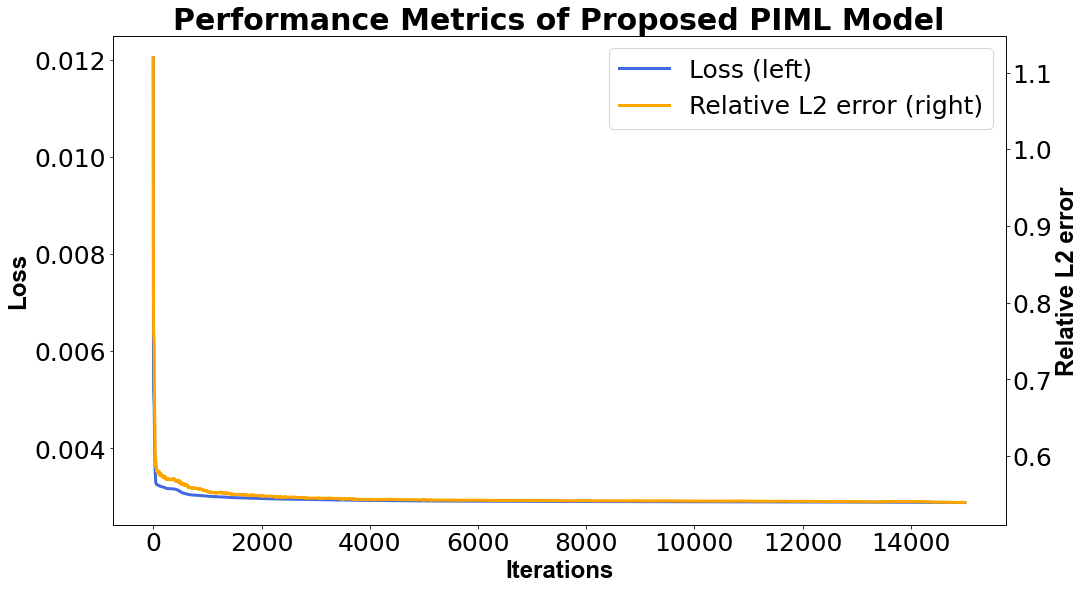

In [17]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Proposed PIML Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [18]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  0.0207196850856001
MSE =  0.002754497995797902
RMSE =  0.05248331159328556
L2 relative error = 0.5049599754805895
--------------------------------------------------


Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

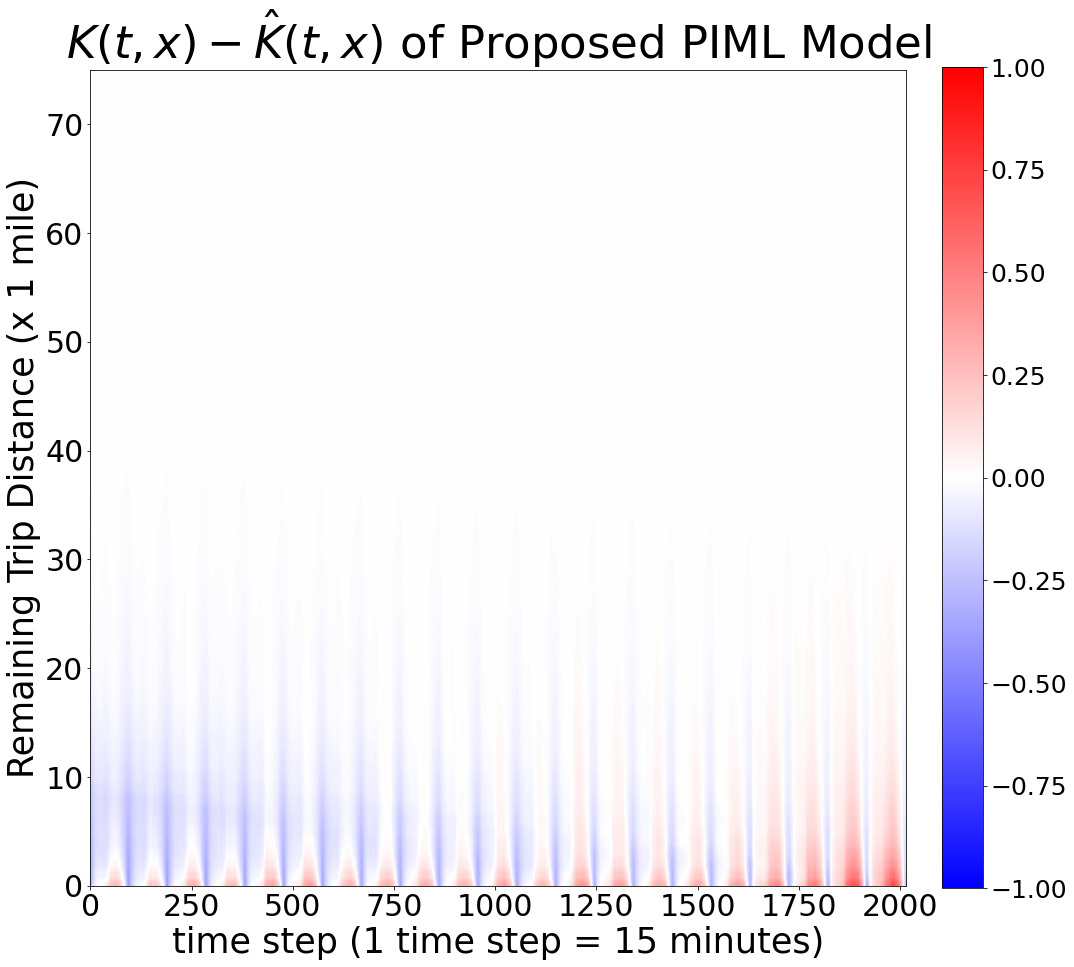

In [19]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

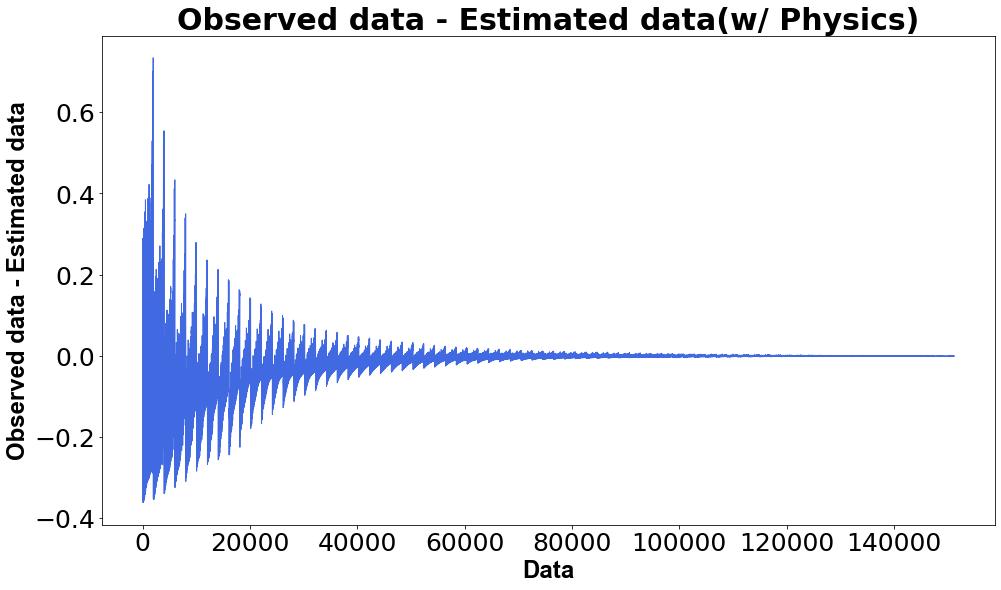

In [20]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)

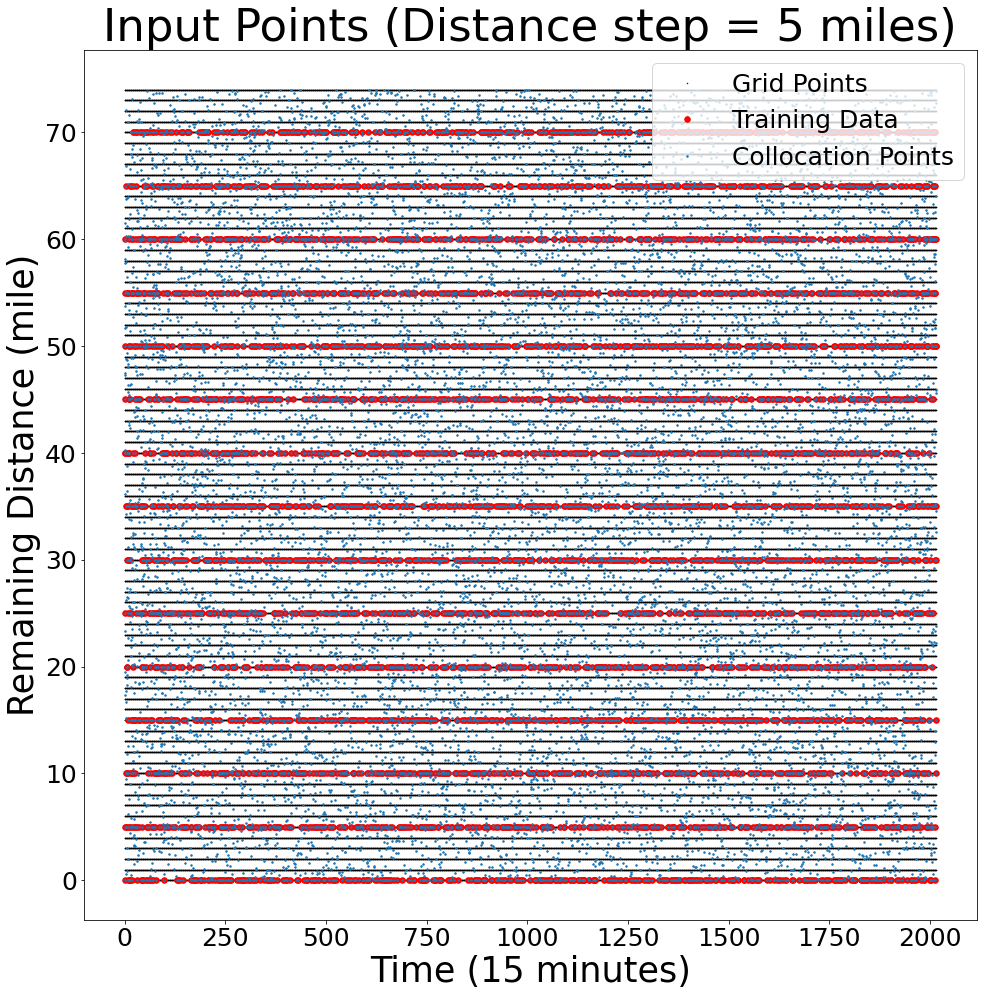

In [21]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_grid[:,1]*multiplier_time, X_u_grid[:,0]*multiplier_dist, 'o', color = 'black', markersize = 0.5, label = 'Grid Points')
plt.plot(X_u_train[:,1]*multiplier_time, X_u_train[:,0]*multiplier_dist, 'o', color = 'red', markersize = 5.5, label = 'Training Data')
plt.plot(X_f_train[:,1]*multiplier_time, X_f_train[:,0]*multiplier_dist, 'o', markersize = 1.5, label = 'Collocation Points')

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.title('Input Points (Distance step = 5 miles)', fontsize=45)
plt.legend(loc='upper right')
plt.show()

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

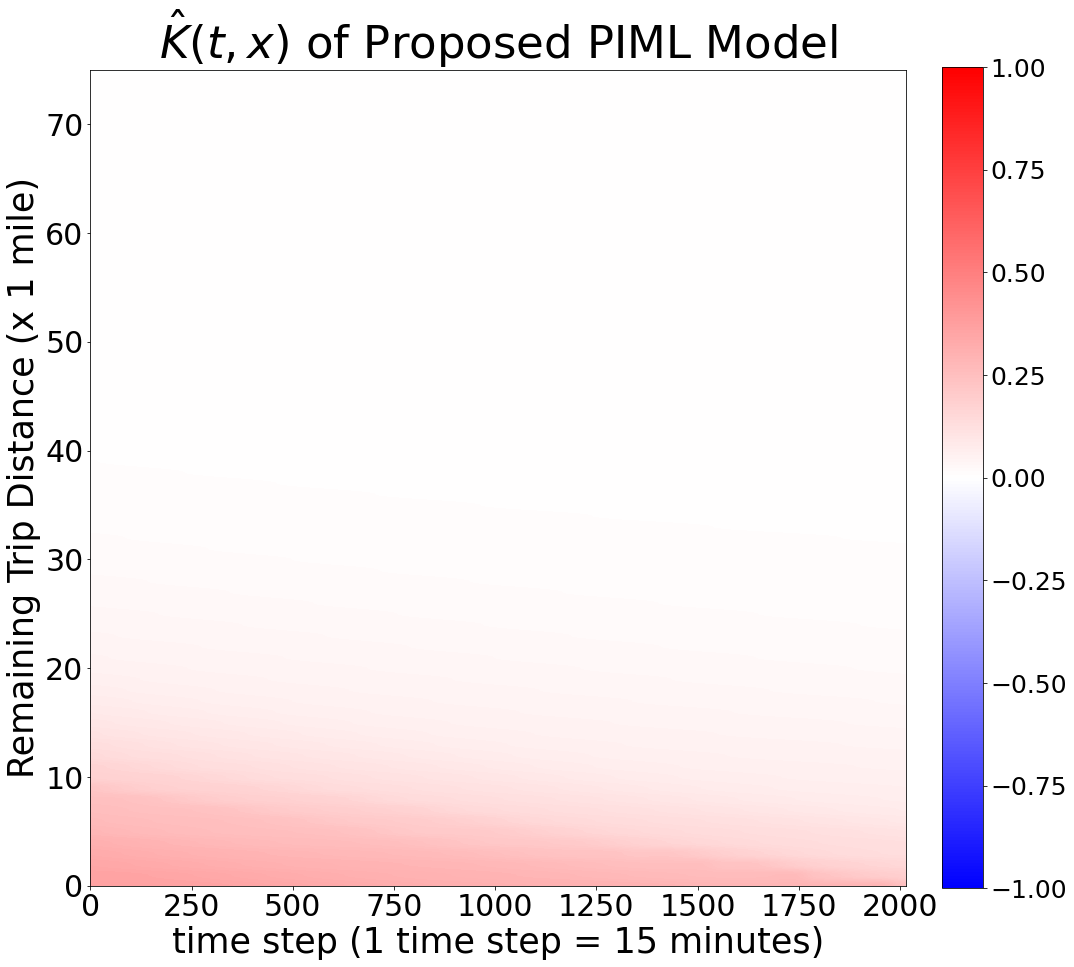

In [22]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)